In [1]:
# %%time
## Just an easy way to load utility functions
dataset_name = "W19_only"
df_list = []

%matplotlib inline 
%run f2f_header.py {dataset_name} {df_list}


Toggle code

In [2]:
global BES_label_list, BES_df_list

# %run f2f_utility.py

BES_df_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_df_list.pickle", "rb" ) )
f2f_harmonised = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')
BES_label_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_label_list.pickle", "rb" ) )
demo_var_dict = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\demo_var_dict.pickle", "rb" ) )
var_type_dict_nonans = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\var_type_dict_nonans.pickle", "rb" ) )

generic_cols = f2f_harmonised.columns
list_of_scale_harm_vars = ["Age","year_past_min_sch_leave_age","in_school_past_min_age"]



## BUGS

BES_label_list["1959"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'
BES_label_list["1964"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'
BES_label_list["1966"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'
BES_label_list["1970"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'

BES_label_list["2015"]['edlevel'] = 'Education level (summary)'



In [3]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
import time
# from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical
# from tensorflow.python.keras.utils import to_categorical

import shap
from tensorflow.python.ops import gradients_impl as tf_gradients_impl
tf_gradients_impl._IsBackpropagatable=True

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, losses
from tensorflow.python.keras.datasets import fashion_mnist
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from tensorflow.python.keras.layers import InputLayer
from sklearn.preprocessing import OneHotEncoder

from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input, Dense, Layer, InputSpec
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.constraints import UnitNorm, Constraint

In [5]:
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = K.transpose(w)
        if(self.encoding_dim > 1):
            m = K.dot(K.transpose(w), w) - K.eye(self.encoding_dim)
            return self.weightage * K.sqrt(K.sum(K.square(m)))
        else:
            m = K.sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)
    
class UncorrelatedFeaturesConstraint(Constraint):
    
    def __init__(self, encoding_dim, weightage = 1.0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
    
    def get_covariance(self, x):
        x_centered_list = []

        for i in range(self.encoding_dim):
            x_centered_list.append(x[:, i] - K.mean(x[:, i]))
        
        x_centered = tf.stack(x_centered_list)
        covariance = K.dot(x_centered, K.transpose(x_centered)) / tf.cast(x_centered.get_shape()[0], tf.float32)
        
        return covariance
            
    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.encoding_dim <= 1):
            return 0.0
        else:
#             output = K.sum(K.square(
#                 self.covariance - tf.matmul(self.covariance, K.eye(self.encoding_dim))))
            output = tf.reduce_sum(tf.square(
                self.covariance - tf.matmul(self.covariance, tf.eye(self.encoding_dim))))            
            
            # FIXED ???
         # still don't know what the problem is here!
# https://stackoverflow.com/questions/57836849/tensorflow-keras-custom-constraint-not-working        
# https://stackoverflow.com/questions/53751024/tying-autoencoder-weights-in-a-dense-keras-layer        
        
            # tf.math.multiply
            return output

    def __call__(self, x):
        self.covariance = self.get_covariance(x)
        return self.weightage * self.uncorrelated_feature(x)   
    
def extract_layers(main_model, starting_layer_ix, ending_layer_ix, input_shape):
  # create an empty model
    new_model = Sequential()
    first_layer =True
    for ix in range(starting_layer_ix, ending_layer_ix + 1):
        curr_layer = main_model.get_layer(index=ix)
        # copy this layer over to the new model
        if first_layer:
            new_model.add(input_shape)
            first_layer=False
        new_model.add(curr_layer)
    return new_model    

In [6]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

def balanced_cross_entropy(y_true, y_pred):
    
    beta = beta = tf.reduce_mean(1 - y_true)
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = (1 - beta) * tf.cast(1 - y_true, tf.float32)

    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
    return tf.reduce_mean(o)

In [74]:
# all layers
def get_kernel_regularizer(orthogonality_constraint,dimension,axis,weight=10e-7,weightage=1.0):
    if orthogonality_constraint:
        return WeightsOrthogonalityConstraint(dimension, weightage=weightage, axis=axis)
    else:
        return regularizers.l2(weight)

# just encoding layer (all of them or just final? Just final surely?)
def get_activity_regularizer(uncorrelated_features,encoding_dim, weightage = 1.):
    if uncorrelated_features:
        return UncorrelatedFeaturesConstraint(encoding_dim, weightage = 1.)
    else:
        return None

# all layers: kernel_constraint=get_kernel_constraint(unit_norm, axis)
def get_kernel_constraint(unit_norm, axis):
    if unit_norm:
        return UnitNorm(axis=axis)
    else:
        return None    

def run_autoencoder(encoding_dim=32,hidden_size=100,verbose=2,
                    loss='mean_squared_error',metrics=['accuracy','mse'],optimizer='adam',
                    penultimate_act = 'relu',ultimate_act = 'linear',max_epochs=100,
                    no_hidden_layers=1,
                    tied_layers = False, orthogonality_constraint = False,uncorrelated_features=False,unit_norm=False,
                    regularizer_weight=10e-7):

    # get rough intermediate sizes for hidden layers
    x = pow(X.shape[1]/encoding_dim,1/ (no_hidden_layers+1) )
    if no_hidden_layers!=1:
        hidden_layer_size = [int(encoding_dim*pow(x,y)) for y in range(1,no_hidden_layers+1)]
    else:
        hidden_layer_size = [hidden_size]
    
     
    
    # Single fully-connected neural layer as encoder and decoder
    use_regularizer = True
#     my_regularizer = None
#     my_epochs = 50
    features_path = 'simple_autoe_features.pickle'
    labels_path = 'simple_autoe_labels.pickle'

    early_stopping_monitor = EarlyStopping(patience=10)

    if use_regularizer:
        # add a sparsity constraint on the encoded representations
        # note use of 10e-5 leads to blurred results
    #     my_regularizer = regularizers.l1(10e-8)
        # and a larger number of epochs as the added regularization the model
        # is less likely to overfit and can be trained longer
#         my_epochs = 100
        features_path = 'sparse_autoe_features.pickle'
        labels_path = 'sparse_autoe_labels.pickle'

    # this is the size of our encoded representations
    # encoding_dim = encoding_dim   # 32 floats -> compression factor 24.5, assuming the input is 784 floats
    # hidden_size = hidden_size

# encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias=True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)) 
# decoder = Dense(input_dim, activation="linear", use_bias = True,
#                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=1))    


    

    # this is our input placeholder; 784 = 28 x 28
    # input_img = Input(shape=(784, ))

    input_img = Input(shape=(X.shape[1], ))

    encoder_list = []
    
    # "encoded" is the encoded representation of the inputs
    hidden_encoder = input_img
    for hidden_layer_number in range(no_hidden_layers-1,-1,-1):       
        
        d = Dense(hidden_layer_size[hidden_layer_number], activation = penultimate_act,
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                                    hidden_layer_size[hidden_layer_number],
                                                                    axis=0, weight=regularizer_weight),
                          kernel_constraint=get_kernel_constraint(unit_norm, axis=0)
                 )
        
        hidden_encoder = d(hidden_encoder)
        encoder_list.append(d)
    
    d = Dense(encoding_dim, activation=penultimate_act,
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                encoding_dim,
                                                axis=0, weight=regularizer_weight),
                          activity_regularizer= get_activity_regularizer(uncorrelated_features,encoding_dim, weightage = 1.),
                          kernel_constraint=get_kernel_constraint(unit_norm, axis=0)
             )
    
    encoded = d(hidden_encoder)
    encoder_list.append(d)
    # encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)


    # "decoded" is the lossy reconstruction of the input
    # decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
    
    
#     decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = True)   
    
    hidden_decoder = encoded
    for hidden_layer_number in range(0,no_hidden_layers):
        if tied_layers:
            hidden_decoder = DenseTied(hidden_layer_size[hidden_layer_number], activation = penultimate_act,
                                      tied_to=encoder_list[no_hidden_layers-hidden_layer_number],
                                      kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                                    ([encoding_dim]+hidden_layer_size)[hidden_layer_number],
                                                                    axis=1, weight=regularizer_weight),  
                                      kernel_constraint=get_kernel_constraint(unit_norm, axis=1),
                                      )(hidden_decoder)
            
        else:
            hidden_decoder = Dense(hidden_layer_size[hidden_layer_number], activation = penultimate_act,
                                      kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                                ([encoding_dim]+hidden_layer_size)[hidden_layer_number],
                                                 axis=1, weight=regularizer_weight),   
                                      kernel_constraint=get_kernel_constraint(unit_norm, axis=1)
                                      )(hidden_decoder)
            
    if tied_layers:
        decoded = DenseTied(X.shape[1], activation=ultimate_act,
                          tied_to=encoder_list[0],
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                    ([encoding_dim]+hidden_layer_size)[no_hidden_layers],
                                     axis=1, weight=regularizer_weight),   
                                     kernel_constraint=get_kernel_constraint(unit_norm, axis=1)
                           )(hidden_decoder)

    else:            
        decoded = Dense(X.shape[1], activation=ultimate_act,
                          kernel_regularizer=get_kernel_regularizer(orthogonality_constraint,
                                    ([encoding_dim]+hidden_layer_size)[no_hidden_layers],
                                     axis=1, weight=regularizer_weight),  
                          kernel_constraint=get_kernel_constraint(unit_norm, axis=1)
                       )(hidden_decoder)
    # decoded = Dense(X.shape[1], activation='linear')(encoded)
    # decoded = Dense(X.shape[1], activation='softmax')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # Separate Encoder model

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # Separate Decoder model

    # create a placeholder for an encoded (32-dimensional) input
#     encoded_input = Input(shape=(encoding_dim,))
    # hidden_layer_input = Input(shape=(hidden_size,))
    # retrieve the last layer of the autoencoder model
    ## changed to -2 after adding hidden layer!
    # decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    # decoder = Model(encoded_input, decoder_layer(hidden_layer_input))
    encoded_input_layer = InputLayer(input_shape=(encoding_dim,))
    # decoder = Model(encoded_input, decoder_layer(encoded_input))

    decoder = extract_layers(autoencoder, -1-no_hidden_layers, -1, encoded_input_layer)

    # Train to reconstruct MNIST digits

    # configure model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.compile( optimizer = optimizer,
    #                loss = 'categorical_crossentropy',
    #                loss = 'categorical_crossentropy',
                   loss = loss,     
                   metrics=metrics)


    # # prepare input data
    # (x_train, _), (x_test, y_test) = mnist.load_data()

    # # normalize all values between 0 and 1 and flatten the 28x28 images into vectors of size 784
    # x_train = x_train.astype('float32') / 255.
    # x_test = x_test.astype('float32') / 255.
    # x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    # x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    # print(x_train.shape)
    # print(x_test.shape)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

    # Train autoencoder for 50 epochs

    if isinstance(X_test, pd.DataFrame):
        X_test_values = X_test.values
        X_train_values = X_train.values
    else:
        X_test_values = X_test
        X_train_values = X_train
    
    autoencoder.fit(X_train_values, X_train_values, epochs=max_epochs, batch_size=512,
                    shuffle=True, validation_data=(X_test_values, X_test_values),
                    verbose=verbose, callbacks=[early_stopping_monitor],
                    use_multiprocessing=True,workers = 4)

    # after 50/100 epochs the autoencoder seems to reach a stable train/test lost value

    # Visualize the reconstructed encoded representations

    # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(X_test_values)
    decoded_imgs = decoder.predict(encoded_imgs)

    # save latent space features 32-d vector
    pickle.dump(encoded_imgs, open(features_path, 'wb'))
    pickle.dump(y_test, open(labels_path, 'wb'))

    # n = 10  # how many digits we will display
    # plt.figure(figsize=(10, 2), dpi=100)
    # for i in range(n):
    #     # display original
    #     ax = plt.subplot(2, n, i + 1)
    #     plt.imshow(x_test[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()

    #     # display reconstruction
    #     ax = plt.subplot(2, n, i + n + 1)
    #     plt.imshow(decoded_imgs[i].reshape(28, 28))
    #     plt.gray()
    #     ax.set_axis_off()kernel_constrain

    # plt.show()
    
    return decoded_imgs,X_test,encoded_imgs,autoencoder,encoder,decoder

In [185]:
ge = "1970"
target_var = "bloc_complete"
drop_vars = [ 'v851','v852','v853','v854','v855','v1214','v1212','v1213','v856','v857a','v857b']
X = BES_df_list[ge][drop_vars].astype('category')
# temp = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,["housing_det","inc_det","age","gender_complete"]]
# X[temp.columns] = temp
# X[["housing_det","inc_det"]] = X[["housing_det","inc_det"]].astype('category')
# X["housing_det"] = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"housing_det"].astype('category')#.cat.codes

y = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,target_var].astype('category')


# df[target_var] = df[target_var].astype('category')
# y.value_counts()

X = X[y.notnull()]
y = y[y.notnull()]

# y = to_categorical(y)
old_y = y

y = to_categorical(y.cat.codes)
X = pd.get_dummies(X)


In [14]:
# X = df_simp.copy()
# y = df_simp[search(df_simp,"REGION").index[0]]

In [50]:
losses2 = pd.DataFrame(columns = ['encoding_dim','hidden_size','num_epochs',
                                 'val_loss', 'val_acc', 'val_mean_squared_error', 'val_binary_accuracy',
                                 'val_binary_crossentropy', 'val_kullback_leibler_divergence','val_matthews_correlation' ,'loss', 'acc',
                                 'mean_squared_error', 'binary_accuracy', 'binary_crossentropy', 'kullback_leibler_divergence','something else',
                                 'mean_correlation','no_hidden_layers','elapsed_time','description','regularizer_weight','lr'])
count = 0
losses2["tied_layer"] = False
losses2["uncorrelated_features"] = True
losses2["unit_norm"] = False

In [87]:
%%time
description="trying to nail down best lr_rate"

hidden_size=50

# originally True
tied_layers=False
uncorrelated_features=True  ### this one broke with new code! ### FIXED

orthogonality_constraint=False ### broken
unit_norm=False

regularizer_weight=10e-5
# test this again
# try l1 regularizer?
no_hidden_layers=1
shuffle=True
batch_size=512
lr = .004

# bit_flip = .999
loss = 'binary_crossentropy'
# loss = dice_loss
# loss = balanced_cross_entropy
metrics = ['accuracy',
            'mse',
            'binary_accuracy',
            'binary_crossentropy',
            'kullback_leibler_divergence',
            matthews_correlation,
            ]


for encoding_dim in [5]:
#[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    
#     for regularizer_weight in [10e-5]:
#     for lr in [.004]:
    for hidden_size in [50]:
    #[10e-6,10e-7,10e-8]:
        optimizer = tf.keras.optimizers.Adamax(lr=lr)    
        # , beta_1=0.9, beta_2=0.999, epsilon=1e-07
        for no_hidden_layers in [1]:
        #[0,1,2,3]:
        #[ [1,0,1,0],[1,1,1,0],[1,0,1,1],[1,1,1,1], ]:
        
#             (tied_layers,orthogonality_constraint,uncorrelated_features,unit_norm) = (bool(x) for x in combo)   
#         for regularizer_weight in [10e-8]:

#             description = str("learning_rate="+str(lr))
            description = "full dataset with hidden layers="+str(no_hidden_layers)
            start_time = time.time()
            print("encoding_dim = "+str(encoding_dim),"hidden_size = "+str(hidden_size),"no_hidden_layers = ",str(no_hidden_layers))
            
            decoded_imgs,X_test,encoded_imgs,autoencoder,encoder,decoder = run_autoencoder(encoding_dim=encoding_dim,
                                                                                           hidden_size=hidden_size,
                                                                                           verbose=2,
                                                                                           loss=loss,
                                                                                           ultimate_act='sigmoid',
                                                                                           metrics=metrics,
                                                                                          max_epochs=2000,
                                                                                          no_hidden_layers=no_hidden_layers,
                                                                                          tied_layers=tied_layers,
                                                                                          orthogonality_constraint=orthogonality_constraint,
                                                                                          uncorrelated_features=uncorrelated_features,
                                                                                          unit_norm=unit_norm,
                                                                                          regularizer_weight=regularizer_weight,
                                                                                          optimizer=optimizer,
                                                                                          )

            X_test = pd.DataFrame(X_test)

            X_test_reconst = pd.DataFrame(decoded_imgs)
            X_test_reconst.columns = X_test.columns
            X_test_reconst.index = X_test.index
            mean_correlation  = X_test_reconst.apply(lambda x: X_test_reconst[x.name].corr( X_test[x.name] ) ).mean()        

    #         X_test_reconst = pd.DataFrame(decoded_imgs,columns=X_test.columns,index=X_test.index)
    #         X_test_reconst["p_past_vote_2019_Conservative"].hist(bins=100)
    #         print("p_past_vote_2019_Conservative correlation =")
    #         print(X_test_reconst["p_past_vote_2019_Conservative"].corr(X_test["p_past_vote_2019_Conservative"]))
            print("mean correlation =")
            print(mean_correlation)
            elapsed_time = time.time() - start_time
            print("elapsed_time = ",elapsed_time)
            losses2.loc[count] = [encoding_dim,hidden_size]+[autoencoder.history.epoch[-1]]+[x[-1] for x in autoencoder.history.history.values()]\
                +[mean_correlation]+[no_hidden_layers]+[elapsed_time]+[description]+[regularizer_weight]\
                +[lr]+[tied_layers]+[uncorrelated_features]+[unit_norm]
            count=count+1        

encoding_dim = 5 hidden_size = 50 no_hidden_layers =  1
Epoch 1/2000
4/4 - 1s - loss: 0.6944 - accuracy: 0.0000e+00 - mse: 0.2440 - binary_accuracy: 0.6289 - binary_crossentropy: 0.6811 - kullback_leibler_divergence: 7.6280 - matthews_correlation: 0.0974 - val_loss: 0.6708 - val_accuracy: 0.0000e+00 - val_mse: 0.2325 - val_binary_accuracy: 0.7118 - val_binary_crossentropy: 0.6581 - val_kullback_leibler_divergence: 7.6594 - val_matthews_correlation: 0.1626
Epoch 2/2000
4/4 - 0s - loss: 0.6528 - accuracy: 0.0000e+00 - mse: 0.2239 - binary_accuracy: 0.7385 - binary_crossentropy: 0.6404 - kullback_leibler_divergence: 7.6952 - matthews_correlation: 0.1975 - val_loss: 0.6165 - val_accuracy: 0.0000e+00 - val_mse: 0.2064 - val_binary_accuracy: 0.7680 - val_binary_crossentropy: 0.6045 - val_kullback_leibler_divergence: 7.8216 - val_matthews_correlation: 0.2469
Epoch 3/2000
4/4 - 0s - loss: 0.5912 - accuracy: 0.0000e+00 - mse: 0.1946 - binary_accuracy: 0.7952 - binary_crossentropy: 0.5795 - kull

Epoch 22/2000
4/4 - 0s - loss: 0.2163 - accuracy: 0.0000e+00 - mse: 0.0638 - binary_accuracy: 0.9118 - binary_crossentropy: 0.2069 - kullback_leibler_divergence: 8.9817 - matthews_correlation: 0.6031 - val_loss: 0.2123 - val_accuracy: 0.0000e+00 - val_mse: 0.0624 - val_binary_accuracy: 0.9133 - val_binary_crossentropy: 0.2029 - val_kullback_leibler_divergence: 8.8200 - val_matthews_correlation: 0.6105
Epoch 23/2000
4/4 - 0s - loss: 0.2134 - accuracy: 0.0000e+00 - mse: 0.0628 - binary_accuracy: 0.9126 - binary_crossentropy: 0.2040 - kullback_leibler_divergence: 8.8717 - matthews_correlation: 0.6074 - val_loss: 0.2093 - val_accuracy: 0.0000e+00 - val_mse: 0.0613 - val_binary_accuracy: 0.9152 - val_binary_crossentropy: 0.1999 - val_kullback_leibler_divergence: 8.7201 - val_matthews_correlation: 0.6213
Epoch 24/2000
4/4 - 0s - loss: 0.2105 - accuracy: 0.0000e+00 - mse: 0.0617 - binary_accuracy: 0.9147 - binary_crossentropy: 0.2011 - kullback_leibler_divergence: 8.7801 - matthews_correlatio

Epoch 43/2000
4/4 - 0s - loss: 0.1713 - accuracy: 0.0000e+00 - mse: 0.0490 - binary_accuracy: 0.9321 - binary_crossentropy: 0.1608 - kullback_leibler_divergence: 7.3044 - matthews_correlation: 0.7042 - val_loss: 0.1690 - val_accuracy: 0.0000e+00 - val_mse: 0.0483 - val_binary_accuracy: 0.9338 - val_binary_crossentropy: 0.1585 - val_kullback_leibler_divergence: 7.2234 - val_matthews_correlation: 0.7116
Epoch 44/2000
4/4 - 0s - loss: 0.1704 - accuracy: 0.0000e+00 - mse: 0.0488 - binary_accuracy: 0.9328 - binary_crossentropy: 0.1599 - kullback_leibler_divergence: 7.2756 - matthews_correlation: 0.7067 - val_loss: 0.1682 - val_accuracy: 0.0000e+00 - val_mse: 0.0480 - val_binary_accuracy: 0.9352 - val_binary_crossentropy: 0.1576 - val_kullback_leibler_divergence: 7.1867 - val_matthews_correlation: 0.7184
Epoch 45/2000
4/4 - 0s - loss: 0.1696 - accuracy: 0.0000e+00 - mse: 0.0485 - binary_accuracy: 0.9341 - binary_crossentropy: 0.1591 - kullback_leibler_divergence: 7.2328 - matthews_correlatio

Epoch 64/2000
4/4 - 0s - loss: 0.1484 - accuracy: 0.0000e+00 - mse: 0.0408 - binary_accuracy: 0.9449 - binary_crossentropy: 0.1367 - kullback_leibler_divergence: 6.1590 - matthews_correlation: 0.7640 - val_loss: 0.1452 - val_accuracy: 0.0000e+00 - val_mse: 0.0396 - val_binary_accuracy: 0.9470 - val_binary_crossentropy: 0.1334 - val_kullback_leibler_divergence: 6.0427 - val_matthews_correlation: 0.7728
Epoch 65/2000
4/4 - 0s - loss: 0.1462 - accuracy: 0.0000e+00 - mse: 0.0399 - binary_accuracy: 0.9472 - binary_crossentropy: 0.1343 - kullback_leibler_divergence: 6.0777 - matthews_correlation: 0.7740 - val_loss: 0.1429 - val_accuracy: 0.0000e+00 - val_mse: 0.0387 - val_binary_accuracy: 0.9485 - val_binary_crossentropy: 0.1310 - val_kullback_leibler_divergence: 5.9492 - val_matthews_correlation: 0.7796
Epoch 66/2000
4/4 - 0s - loss: 0.1438 - accuracy: 0.0000e+00 - mse: 0.0391 - binary_accuracy: 0.9485 - binary_crossentropy: 0.1319 - kullback_leibler_divergence: 5.9766 - matthews_correlatio

Epoch 85/2000
4/4 - 0s - loss: 0.1131 - accuracy: 0.0000e+00 - mse: 0.0289 - binary_accuracy: 0.9611 - binary_crossentropy: 0.0992 - kullback_leibler_divergence: 4.4224 - matthews_correlation: 0.8374 - val_loss: 0.1131 - val_accuracy: 0.0000e+00 - val_mse: 0.0289 - val_binary_accuracy: 0.9611 - val_binary_crossentropy: 0.0992 - val_kullback_leibler_divergence: 4.4846 - val_matthews_correlation: 0.8370
Epoch 86/2000
4/4 - 0s - loss: 0.1124 - accuracy: 0.0000e+00 - mse: 0.0287 - binary_accuracy: 0.9614 - binary_crossentropy: 0.0985 - kullback_leibler_divergence: 4.4085 - matthews_correlation: 0.8386 - val_loss: 0.1126 - val_accuracy: 0.0000e+00 - val_mse: 0.0287 - val_binary_accuracy: 0.9612 - val_binary_crossentropy: 0.0986 - val_kullback_leibler_divergence: 4.4591 - val_matthews_correlation: 0.8374
Epoch 87/2000
4/4 - 0s - loss: 0.1118 - accuracy: 0.0000e+00 - mse: 0.0285 - binary_accuracy: 0.9615 - binary_crossentropy: 0.0978 - kullback_leibler_divergence: 4.3537 - matthews_correlatio

Epoch 106/2000
4/4 - 0s - loss: 0.1042 - accuracy: 0.0000e+00 - mse: 0.0258 - binary_accuracy: 0.9648 - binary_crossentropy: 0.0893 - kullback_leibler_divergence: 3.9784 - matthews_correlation: 0.8536 - val_loss: 0.1054 - val_accuracy: 0.0000e+00 - val_mse: 0.0261 - val_binary_accuracy: 0.9643 - val_binary_crossentropy: 0.0905 - val_kullback_leibler_divergence: 4.0635 - val_matthews_correlation: 0.8508
Epoch 107/2000
4/4 - 0s - loss: 0.1039 - accuracy: 0.0000e+00 - mse: 0.0257 - binary_accuracy: 0.9651 - binary_crossentropy: 0.0890 - kullback_leibler_divergence: 3.9442 - matthews_correlation: 0.8551 - val_loss: 0.1051 - val_accuracy: 0.0000e+00 - val_mse: 0.0260 - val_binary_accuracy: 0.9646 - val_binary_crossentropy: 0.0902 - val_kullback_leibler_divergence: 4.0473 - val_matthews_correlation: 0.8525
Epoch 108/2000
4/4 - 0s - loss: 0.1035 - accuracy: 0.0000e+00 - mse: 0.0256 - binary_accuracy: 0.9655 - binary_crossentropy: 0.0886 - kullback_leibler_divergence: 3.9266 - matthews_correla

Epoch 127/2000
4/4 - 0s - loss: 0.0979 - accuracy: 0.0000e+00 - mse: 0.0234 - binary_accuracy: 0.9683 - binary_crossentropy: 0.0822 - kullback_leibler_divergence: 3.6603 - matthews_correlation: 0.8683 - val_loss: 0.0995 - val_accuracy: 0.0000e+00 - val_mse: 0.0238 - val_binary_accuracy: 0.9669 - val_binary_crossentropy: 0.0838 - val_kullback_leibler_divergence: 3.7778 - val_matthews_correlation: 0.8623
Epoch 128/2000
4/4 - 0s - loss: 0.0976 - accuracy: 0.0000e+00 - mse: 0.0233 - binary_accuracy: 0.9685 - binary_crossentropy: 0.0819 - kullback_leibler_divergence: 3.6586 - matthews_correlation: 0.8691 - val_loss: 0.0991 - val_accuracy: 0.0000e+00 - val_mse: 0.0237 - val_binary_accuracy: 0.9674 - val_binary_crossentropy: 0.0833 - val_kullback_leibler_divergence: 3.7593 - val_matthews_correlation: 0.8645
Epoch 129/2000
4/4 - 0s - loss: 0.0973 - accuracy: 0.0000e+00 - mse: 0.0232 - binary_accuracy: 0.9688 - binary_crossentropy: 0.0815 - kullback_leibler_divergence: 3.6420 - matthews_correla

Epoch 148/2000
4/4 - 0s - loss: 0.0922 - accuracy: 0.0000e+00 - mse: 0.0213 - binary_accuracy: 0.9714 - binary_crossentropy: 0.0757 - kullback_leibler_divergence: 3.3943 - matthews_correlation: 0.8815 - val_loss: 0.0939 - val_accuracy: 0.0000e+00 - val_mse: 0.0217 - val_binary_accuracy: 0.9709 - val_binary_crossentropy: 0.0774 - val_kullback_leibler_divergence: 3.4888 - val_matthews_correlation: 0.8793
Epoch 149/2000
4/4 - 0s - loss: 0.0920 - accuracy: 0.0000e+00 - mse: 0.0212 - binary_accuracy: 0.9716 - binary_crossentropy: 0.0755 - kullback_leibler_divergence: 3.3764 - matthews_correlation: 0.8821 - val_loss: 0.0937 - val_accuracy: 0.0000e+00 - val_mse: 0.0217 - val_binary_accuracy: 0.9714 - val_binary_crossentropy: 0.0772 - val_kullback_leibler_divergence: 3.4734 - val_matthews_correlation: 0.8816
Epoch 150/2000
4/4 - 0s - loss: 0.0917 - accuracy: 0.0000e+00 - mse: 0.0212 - binary_accuracy: 0.9718 - binary_crossentropy: 0.0752 - kullback_leibler_divergence: 3.3594 - matthews_correla

Epoch 169/2000
4/4 - 0s - loss: 0.0871 - accuracy: 0.0000e+00 - mse: 0.0195 - binary_accuracy: 0.9743 - binary_crossentropy: 0.0698 - kullback_leibler_divergence: 3.1128 - matthews_correlation: 0.8941 - val_loss: 0.0888 - val_accuracy: 0.0000e+00 - val_mse: 0.0198 - val_binary_accuracy: 0.9741 - val_binary_crossentropy: 0.0715 - val_kullback_leibler_divergence: 3.1977 - val_matthews_correlation: 0.8930
Epoch 170/2000
4/4 - 0s - loss: 0.0869 - accuracy: 0.0000e+00 - mse: 0.0194 - binary_accuracy: 0.9746 - binary_crossentropy: 0.0696 - kullback_leibler_divergence: 3.0958 - matthews_correlation: 0.8952 - val_loss: 0.0886 - val_accuracy: 0.0000e+00 - val_mse: 0.0197 - val_binary_accuracy: 0.9741 - val_binary_crossentropy: 0.0712 - val_kullback_leibler_divergence: 3.2062 - val_matthews_correlation: 0.8928
Epoch 171/2000
4/4 - 0s - loss: 0.0867 - accuracy: 0.0000e+00 - mse: 0.0193 - binary_accuracy: 0.9748 - binary_crossentropy: 0.0693 - kullback_leibler_divergence: 3.1008 - matthews_correla

Epoch 190/2000
4/4 - 0s - loss: 0.0829 - accuracy: 0.0000e+00 - mse: 0.0178 - binary_accuracy: 0.9769 - binary_crossentropy: 0.0648 - kullback_leibler_divergence: 2.8927 - matthews_correlation: 0.9047 - val_loss: 0.0847 - val_accuracy: 0.0000e+00 - val_mse: 0.0182 - val_binary_accuracy: 0.9762 - val_binary_crossentropy: 0.0666 - val_kullback_leibler_divergence: 2.9895 - val_matthews_correlation: 0.9017
Epoch 191/2000
4/4 - 0s - loss: 0.0827 - accuracy: 0.0000e+00 - mse: 0.0178 - binary_accuracy: 0.9769 - binary_crossentropy: 0.0646 - kullback_leibler_divergence: 2.8816 - matthews_correlation: 0.9049 - val_loss: 0.0845 - val_accuracy: 0.0000e+00 - val_mse: 0.0182 - val_binary_accuracy: 0.9761 - val_binary_crossentropy: 0.0664 - val_kullback_leibler_divergence: 2.9896 - val_matthews_correlation: 0.9016
Epoch 192/2000
4/4 - 0s - loss: 0.0825 - accuracy: 0.0000e+00 - mse: 0.0177 - binary_accuracy: 0.9769 - binary_crossentropy: 0.0643 - kullback_leibler_divergence: 2.8783 - matthews_correla

Epoch 211/2000
4/4 - 0s - loss: 0.0795 - accuracy: 0.0000e+00 - mse: 0.0166 - binary_accuracy: 0.9789 - binary_crossentropy: 0.0608 - kullback_leibler_divergence: 2.7139 - matthews_correlation: 0.9135 - val_loss: 0.0814 - val_accuracy: 0.0000e+00 - val_mse: 0.0170 - val_binary_accuracy: 0.9778 - val_binary_crossentropy: 0.0627 - val_kullback_leibler_divergence: 2.8438 - val_matthews_correlation: 0.9088
Epoch 212/2000
4/4 - 0s - loss: 0.0793 - accuracy: 0.0000e+00 - mse: 0.0166 - binary_accuracy: 0.9788 - binary_crossentropy: 0.0606 - kullback_leibler_divergence: 2.7214 - matthews_correlation: 0.9128 - val_loss: 0.0814 - val_accuracy: 0.0000e+00 - val_mse: 0.0171 - val_binary_accuracy: 0.9778 - val_binary_crossentropy: 0.0627 - val_kullback_leibler_divergence: 2.8459 - val_matthews_correlation: 0.9086
Epoch 213/2000
4/4 - 0s - loss: 0.0792 - accuracy: 0.0000e+00 - mse: 0.0166 - binary_accuracy: 0.9790 - binary_crossentropy: 0.0605 - kullback_leibler_divergence: 2.7063 - matthews_correla

Epoch 232/2000
4/4 - 0s - loss: 0.0770 - accuracy: 0.0000e+00 - mse: 0.0158 - binary_accuracy: 0.9797 - binary_crossentropy: 0.0579 - kullback_leibler_divergence: 2.5948 - matthews_correlation: 0.9165 - val_loss: 0.0792 - val_accuracy: 0.0000e+00 - val_mse: 0.0162 - val_binary_accuracy: 0.9791 - val_binary_crossentropy: 0.0600 - val_kullback_leibler_divergence: 2.7280 - val_matthews_correlation: 0.9142
Epoch 233/2000
4/4 - 0s - loss: 0.0769 - accuracy: 0.0000e+00 - mse: 0.0157 - binary_accuracy: 0.9800 - binary_crossentropy: 0.0577 - kullback_leibler_divergence: 2.5875 - matthews_correlation: 0.9179 - val_loss: 0.0791 - val_accuracy: 0.0000e+00 - val_mse: 0.0162 - val_binary_accuracy: 0.9793 - val_binary_crossentropy: 0.0600 - val_kullback_leibler_divergence: 2.7268 - val_matthews_correlation: 0.9150
Epoch 234/2000
4/4 - 0s - loss: 0.0768 - accuracy: 0.0000e+00 - mse: 0.0157 - binary_accuracy: 0.9801 - binary_crossentropy: 0.0577 - kullback_leibler_divergence: 2.5820 - matthews_correla

Epoch 253/2000
4/4 - 0s - loss: 0.0752 - accuracy: 0.0000e+00 - mse: 0.0152 - binary_accuracy: 0.9806 - binary_crossentropy: 0.0558 - kullback_leibler_divergence: 2.5035 - matthews_correlation: 0.9199 - val_loss: 0.0775 - val_accuracy: 0.0000e+00 - val_mse: 0.0157 - val_binary_accuracy: 0.9799 - val_binary_crossentropy: 0.0581 - val_kullback_leibler_divergence: 2.6431 - val_matthews_correlation: 0.9174
Epoch 254/2000
4/4 - 0s - loss: 0.0752 - accuracy: 0.0000e+00 - mse: 0.0152 - binary_accuracy: 0.9810 - binary_crossentropy: 0.0557 - kullback_leibler_divergence: 2.5007 - matthews_correlation: 0.9219 - val_loss: 0.0775 - val_accuracy: 0.0000e+00 - val_mse: 0.0156 - val_binary_accuracy: 0.9805 - val_binary_crossentropy: 0.0580 - val_kullback_leibler_divergence: 2.6516 - val_matthews_correlation: 0.9198
Epoch 255/2000
4/4 - 0s - loss: 0.0751 - accuracy: 0.0000e+00 - mse: 0.0151 - binary_accuracy: 0.9810 - binary_crossentropy: 0.0556 - kullback_leibler_divergence: 2.4972 - matthews_correla

Epoch 274/2000
4/4 - 0s - loss: 0.0737 - accuracy: 0.0000e+00 - mse: 0.0147 - binary_accuracy: 0.9813 - binary_crossentropy: 0.0541 - kullback_leibler_divergence: 2.4217 - matthews_correlation: 0.9237 - val_loss: 0.0761 - val_accuracy: 0.0000e+00 - val_mse: 0.0152 - val_binary_accuracy: 0.9812 - val_binary_crossentropy: 0.0565 - val_kullback_leibler_divergence: 2.5884 - val_matthews_correlation: 0.9228
Epoch 275/2000
4/4 - 0s - loss: 0.0737 - accuracy: 0.0000e+00 - mse: 0.0147 - binary_accuracy: 0.9815 - binary_crossentropy: 0.0540 - kullback_leibler_divergence: 2.4349 - matthews_correlation: 0.9239 - val_loss: 0.0761 - val_accuracy: 0.0000e+00 - val_mse: 0.0152 - val_binary_accuracy: 0.9808 - val_binary_crossentropy: 0.0565 - val_kullback_leibler_divergence: 2.5823 - val_matthews_correlation: 0.9210
Epoch 276/2000
4/4 - 0s - loss: 0.0736 - accuracy: 0.0000e+00 - mse: 0.0147 - binary_accuracy: 0.9812 - binary_crossentropy: 0.0540 - kullback_leibler_divergence: 2.4261 - matthews_correla

Epoch 295/2000
4/4 - 0s - loss: 0.0724 - accuracy: 0.0000e+00 - mse: 0.0143 - binary_accuracy: 0.9820 - binary_crossentropy: 0.0526 - kullback_leibler_divergence: 2.3628 - matthews_correlation: 0.9260 - val_loss: 0.0750 - val_accuracy: 0.0000e+00 - val_mse: 0.0148 - val_binary_accuracy: 0.9816 - val_binary_crossentropy: 0.0552 - val_kullback_leibler_divergence: 2.5213 - val_matthews_correlation: 0.9242
Epoch 296/2000
4/4 - 0s - loss: 0.0723 - accuracy: 0.0000e+00 - mse: 0.0143 - binary_accuracy: 0.9819 - binary_crossentropy: 0.0525 - kullback_leibler_divergence: 2.3612 - matthews_correlation: 0.9255 - val_loss: 0.0748 - val_accuracy: 0.0000e+00 - val_mse: 0.0147 - val_binary_accuracy: 0.9815 - val_binary_crossentropy: 0.0550 - val_kullback_leibler_divergence: 2.5174 - val_matthews_correlation: 0.9242
Epoch 297/2000
4/4 - 0s - loss: 0.0723 - accuracy: 0.0000e+00 - mse: 0.0142 - binary_accuracy: 0.9818 - binary_crossentropy: 0.0524 - kullback_leibler_divergence: 2.3567 - matthews_correla

Epoch 316/2000
4/4 - 0s - loss: 0.0712 - accuracy: 0.0000e+00 - mse: 0.0139 - binary_accuracy: 0.9823 - binary_crossentropy: 0.0512 - kullback_leibler_divergence: 2.3140 - matthews_correlation: 0.9274 - val_loss: 0.0737 - val_accuracy: 0.0000e+00 - val_mse: 0.0143 - val_binary_accuracy: 0.9820 - val_binary_crossentropy: 0.0536 - val_kullback_leibler_divergence: 2.4352 - val_matthews_correlation: 0.9259
Epoch 317/2000
4/4 - 0s - loss: 0.0711 - accuracy: 0.0000e+00 - mse: 0.0138 - binary_accuracy: 0.9823 - binary_crossentropy: 0.0510 - kullback_leibler_divergence: 2.2729 - matthews_correlation: 0.9272 - val_loss: 0.0737 - val_accuracy: 0.0000e+00 - val_mse: 0.0143 - val_binary_accuracy: 0.9821 - val_binary_crossentropy: 0.0536 - val_kullback_leibler_divergence: 2.4496 - val_matthews_correlation: 0.9263
Epoch 318/2000
4/4 - 0s - loss: 0.0711 - accuracy: 0.0000e+00 - mse: 0.0138 - binary_accuracy: 0.9825 - binary_crossentropy: 0.0510 - kullback_leibler_divergence: 2.3171 - matthews_correla

Epoch 337/2000
4/4 - 0s - loss: 0.0701 - accuracy: 0.0000e+00 - mse: 0.0135 - binary_accuracy: 0.9830 - binary_crossentropy: 0.0499 - kullback_leibler_divergence: 2.2554 - matthews_correlation: 0.9300 - val_loss: 0.0729 - val_accuracy: 0.0000e+00 - val_mse: 0.0140 - val_binary_accuracy: 0.9824 - val_binary_crossentropy: 0.0527 - val_kullback_leibler_divergence: 2.4221 - val_matthews_correlation: 0.9276
Epoch 338/2000
4/4 - 0s - loss: 0.0700 - accuracy: 0.0000e+00 - mse: 0.0135 - binary_accuracy: 0.9828 - binary_crossentropy: 0.0498 - kullback_leibler_divergence: 2.2503 - matthews_correlation: 0.9297 - val_loss: 0.0728 - val_accuracy: 0.0000e+00 - val_mse: 0.0140 - val_binary_accuracy: 0.9823 - val_binary_crossentropy: 0.0525 - val_kullback_leibler_divergence: 2.4122 - val_matthews_correlation: 0.9274
Epoch 339/2000
4/4 - 0s - loss: 0.0700 - accuracy: 0.0000e+00 - mse: 0.0135 - binary_accuracy: 0.9828 - binary_crossentropy: 0.0497 - kullback_leibler_divergence: 2.2460 - matthews_correla

Epoch 358/2000
4/4 - 0s - loss: 0.0691 - accuracy: 0.0000e+00 - mse: 0.0131 - binary_accuracy: 0.9832 - binary_crossentropy: 0.0486 - kullback_leibler_divergence: 2.1902 - matthews_correlation: 0.9313 - val_loss: 0.0720 - val_accuracy: 0.0000e+00 - val_mse: 0.0137 - val_binary_accuracy: 0.9828 - val_binary_crossentropy: 0.0516 - val_kullback_leibler_divergence: 2.3526 - val_matthews_correlation: 0.9293
Epoch 359/2000
4/4 - 0s - loss: 0.0690 - accuracy: 0.0000e+00 - mse: 0.0131 - binary_accuracy: 0.9834 - binary_crossentropy: 0.0486 - kullback_leibler_divergence: 2.1950 - matthews_correlation: 0.9319 - val_loss: 0.0720 - val_accuracy: 0.0000e+00 - val_mse: 0.0137 - val_binary_accuracy: 0.9830 - val_binary_crossentropy: 0.0516 - val_kullback_leibler_divergence: 2.3915 - val_matthews_correlation: 0.9300
Epoch 360/2000
4/4 - 0s - loss: 0.0690 - accuracy: 0.0000e+00 - mse: 0.0131 - binary_accuracy: 0.9835 - binary_crossentropy: 0.0486 - kullback_leibler_divergence: 2.2168 - matthews_correla

Epoch 379/2000
4/4 - 0s - loss: 0.0682 - accuracy: 0.0000e+00 - mse: 0.0128 - binary_accuracy: 0.9840 - binary_crossentropy: 0.0476 - kullback_leibler_divergence: 2.1672 - matthews_correlation: 0.9343 - val_loss: 0.0712 - val_accuracy: 0.0000e+00 - val_mse: 0.0134 - val_binary_accuracy: 0.9832 - val_binary_crossentropy: 0.0506 - val_kullback_leibler_divergence: 2.3165 - val_matthews_correlation: 0.9312
Epoch 380/2000
4/4 - 0s - loss: 0.0681 - accuracy: 0.0000e+00 - mse: 0.0128 - binary_accuracy: 0.9838 - binary_crossentropy: 0.0475 - kullback_leibler_divergence: 2.1386 - matthews_correlation: 0.9337 - val_loss: 0.0712 - val_accuracy: 0.0000e+00 - val_mse: 0.0134 - val_binary_accuracy: 0.9829 - val_binary_crossentropy: 0.0506 - val_kullback_leibler_divergence: 2.3261 - val_matthews_correlation: 0.9299
Epoch 381/2000
4/4 - 0s - loss: 0.0681 - accuracy: 0.0000e+00 - mse: 0.0128 - binary_accuracy: 0.9839 - binary_crossentropy: 0.0475 - kullback_leibler_divergence: 2.1619 - matthews_correla

Epoch 400/2000
4/4 - 0s - loss: 0.0673 - accuracy: 0.0000e+00 - mse: 0.0124 - binary_accuracy: 0.9842 - binary_crossentropy: 0.0465 - kullback_leibler_divergence: 2.1179 - matthews_correlation: 0.9352 - val_loss: 0.0704 - val_accuracy: 0.0000e+00 - val_mse: 0.0131 - val_binary_accuracy: 0.9835 - val_binary_crossentropy: 0.0496 - val_kullback_leibler_divergence: 2.2982 - val_matthews_correlation: 0.9324
Epoch 401/2000
4/4 - 0s - loss: 0.0672 - accuracy: 0.0000e+00 - mse: 0.0124 - binary_accuracy: 0.9843 - binary_crossentropy: 0.0464 - kullback_leibler_divergence: 2.1048 - matthews_correlation: 0.9356 - val_loss: 0.0704 - val_accuracy: 0.0000e+00 - val_mse: 0.0131 - val_binary_accuracy: 0.9832 - val_binary_crossentropy: 0.0496 - val_kullback_leibler_divergence: 2.2722 - val_matthews_correlation: 0.9311
Epoch 402/2000
4/4 - 0s - loss: 0.0672 - accuracy: 0.0000e+00 - mse: 0.0124 - binary_accuracy: 0.9844 - binary_crossentropy: 0.0463 - kullback_leibler_divergence: 2.0998 - matthews_correla

Epoch 421/2000
4/4 - 0s - loss: 0.0664 - accuracy: 0.0000e+00 - mse: 0.0121 - binary_accuracy: 0.9847 - binary_crossentropy: 0.0454 - kullback_leibler_divergence: 2.0503 - matthews_correlation: 0.9370 - val_loss: 0.0697 - val_accuracy: 0.0000e+00 - val_mse: 0.0128 - val_binary_accuracy: 0.9837 - val_binary_crossentropy: 0.0486 - val_kullback_leibler_divergence: 2.2551 - val_matthews_correlation: 0.9329
Epoch 422/2000
4/4 - 0s - loss: 0.0664 - accuracy: 0.0000e+00 - mse: 0.0121 - binary_accuracy: 0.9847 - binary_crossentropy: 0.0453 - kullback_leibler_divergence: 2.0698 - matthews_correlation: 0.9371 - val_loss: 0.0696 - val_accuracy: 0.0000e+00 - val_mse: 0.0128 - val_binary_accuracy: 0.9836 - val_binary_crossentropy: 0.0486 - val_kullback_leibler_divergence: 2.2572 - val_matthews_correlation: 0.9326
Epoch 423/2000
4/4 - 0s - loss: 0.0663 - accuracy: 0.0000e+00 - mse: 0.0121 - binary_accuracy: 0.9847 - binary_crossentropy: 0.0453 - kullback_leibler_divergence: 2.0748 - matthews_correla

Epoch 442/2000
4/4 - 0s - loss: 0.0656 - accuracy: 0.0000e+00 - mse: 0.0118 - binary_accuracy: 0.9850 - binary_crossentropy: 0.0444 - kullback_leibler_divergence: 2.0296 - matthews_correlation: 0.9386 - val_loss: 0.0691 - val_accuracy: 0.0000e+00 - val_mse: 0.0125 - val_binary_accuracy: 0.9842 - val_binary_crossentropy: 0.0479 - val_kullback_leibler_divergence: 2.2289 - val_matthews_correlation: 0.9350
Epoch 443/2000
4/4 - 0s - loss: 0.0656 - accuracy: 0.0000e+00 - mse: 0.0118 - binary_accuracy: 0.9852 - binary_crossentropy: 0.0444 - kullback_leibler_divergence: 2.0321 - matthews_correlation: 0.9392 - val_loss: 0.0692 - val_accuracy: 0.0000e+00 - val_mse: 0.0126 - val_binary_accuracy: 0.9841 - val_binary_crossentropy: 0.0479 - val_kullback_leibler_divergence: 2.2235 - val_matthews_correlation: 0.9345
Epoch 444/2000
4/4 - 0s - loss: 0.0656 - accuracy: 0.0000e+00 - mse: 0.0118 - binary_accuracy: 0.9852 - binary_crossentropy: 0.0443 - kullback_leibler_divergence: 2.0191 - matthews_correla

Epoch 463/2000
4/4 - 0s - loss: 0.0649 - accuracy: 0.0000e+00 - mse: 0.0115 - binary_accuracy: 0.9854 - binary_crossentropy: 0.0435 - kullback_leibler_divergence: 1.9698 - matthews_correlation: 0.9406 - val_loss: 0.0686 - val_accuracy: 0.0000e+00 - val_mse: 0.0123 - val_binary_accuracy: 0.9845 - val_binary_crossentropy: 0.0472 - val_kullback_leibler_divergence: 2.1871 - val_matthews_correlation: 0.9361
Epoch 464/2000
4/4 - 0s - loss: 0.0649 - accuracy: 0.0000e+00 - mse: 0.0115 - binary_accuracy: 0.9854 - binary_crossentropy: 0.0434 - kullback_leibler_divergence: 1.9965 - matthews_correlation: 0.9399 - val_loss: 0.0686 - val_accuracy: 0.0000e+00 - val_mse: 0.0123 - val_binary_accuracy: 0.9844 - val_binary_crossentropy: 0.0471 - val_kullback_leibler_divergence: 2.2130 - val_matthews_correlation: 0.9361
Epoch 465/2000
4/4 - 0s - loss: 0.0649 - accuracy: 0.0000e+00 - mse: 0.0115 - binary_accuracy: 0.9854 - binary_crossentropy: 0.0435 - kullback_leibler_divergence: 1.9937 - matthews_correla

Epoch 484/2000
4/4 - 0s - loss: 0.0642 - accuracy: 0.0000e+00 - mse: 0.0113 - binary_accuracy: 0.9858 - binary_crossentropy: 0.0426 - kullback_leibler_divergence: 1.9567 - matthews_correlation: 0.9416 - val_loss: 0.0680 - val_accuracy: 0.0000e+00 - val_mse: 0.0121 - val_binary_accuracy: 0.9849 - val_binary_crossentropy: 0.0464 - val_kullback_leibler_divergence: 2.1577 - val_matthews_correlation: 0.9379
Epoch 485/2000
4/4 - 0s - loss: 0.0642 - accuracy: 0.0000e+00 - mse: 0.0112 - binary_accuracy: 0.9858 - binary_crossentropy: 0.0426 - kullback_leibler_divergence: 1.9402 - matthews_correlation: 0.9417 - val_loss: 0.0679 - val_accuracy: 0.0000e+00 - val_mse: 0.0121 - val_binary_accuracy: 0.9848 - val_binary_crossentropy: 0.0463 - val_kullback_leibler_divergence: 2.1424 - val_matthews_correlation: 0.9377
Epoch 486/2000
4/4 - 0s - loss: 0.0642 - accuracy: 0.0000e+00 - mse: 0.0113 - binary_accuracy: 0.9858 - binary_crossentropy: 0.0426 - kullback_leibler_divergence: 1.9499 - matthews_correla

Epoch 505/2000
4/4 - 0s - loss: 0.0637 - accuracy: 0.0000e+00 - mse: 0.0110 - binary_accuracy: 0.9861 - binary_crossentropy: 0.0419 - kullback_leibler_divergence: 1.9241 - matthews_correlation: 0.9431 - val_loss: 0.0676 - val_accuracy: 0.0000e+00 - val_mse: 0.0119 - val_binary_accuracy: 0.9851 - val_binary_crossentropy: 0.0458 - val_kullback_leibler_divergence: 2.1268 - val_matthews_correlation: 0.9386
Epoch 506/2000
4/4 - 0s - loss: 0.0637 - accuracy: 5.1099e-04 - mse: 0.0110 - binary_accuracy: 0.9862 - binary_crossentropy: 0.0419 - kullback_leibler_divergence: 1.9064 - matthews_correlation: 0.9432 - val_loss: 0.0676 - val_accuracy: 0.0000e+00 - val_mse: 0.0119 - val_binary_accuracy: 0.9852 - val_binary_crossentropy: 0.0458 - val_kullback_leibler_divergence: 2.1261 - val_matthews_correlation: 0.9393
Epoch 507/2000
4/4 - 0s - loss: 0.0637 - accuracy: 0.0000e+00 - mse: 0.0110 - binary_accuracy: 0.9860 - binary_crossentropy: 0.0419 - kullback_leibler_divergence: 1.9122 - matthews_correla

Epoch 526/2000
4/4 - 0s - loss: 0.0631 - accuracy: 5.1099e-04 - mse: 0.0108 - binary_accuracy: 0.9865 - binary_crossentropy: 0.0412 - kullback_leibler_divergence: 1.8810 - matthews_correlation: 0.9444 - val_loss: 0.0671 - val_accuracy: 0.0000e+00 - val_mse: 0.0117 - val_binary_accuracy: 0.9855 - val_binary_crossentropy: 0.0451 - val_kullback_leibler_divergence: 2.0962 - val_matthews_correlation: 0.9404
Epoch 527/2000
4/4 - 0s - loss: 0.0631 - accuracy: 0.0000e+00 - mse: 0.0108 - binary_accuracy: 0.9864 - binary_crossentropy: 0.0412 - kullback_leibler_divergence: 1.8919 - matthews_correlation: 0.9442 - val_loss: 0.0671 - val_accuracy: 0.0000e+00 - val_mse: 0.0117 - val_binary_accuracy: 0.9854 - val_binary_crossentropy: 0.0452 - val_kullback_leibler_divergence: 2.1215 - val_matthews_correlation: 0.9399
Epoch 528/2000
4/4 - 0s - loss: 0.0630 - accuracy: 0.0000e+00 - mse: 0.0108 - binary_accuracy: 0.9864 - binary_crossentropy: 0.0411 - kullback_leibler_divergence: 1.8862 - matthews_correla

Epoch 547/2000
4/4 - 0s - loss: 0.0626 - accuracy: 0.0000e+00 - mse: 0.0106 - binary_accuracy: 0.9867 - binary_crossentropy: 0.0405 - kullback_leibler_divergence: 1.8633 - matthews_correlation: 0.9455 - val_loss: 0.0666 - val_accuracy: 0.0000e+00 - val_mse: 0.0115 - val_binary_accuracy: 0.9857 - val_binary_crossentropy: 0.0445 - val_kullback_leibler_divergence: 2.0883 - val_matthews_correlation: 0.9411
Epoch 548/2000
4/4 - 0s - loss: 0.0626 - accuracy: 0.0000e+00 - mse: 0.0106 - binary_accuracy: 0.9867 - binary_crossentropy: 0.0405 - kullback_leibler_divergence: 1.8609 - matthews_correlation: 0.9452 - val_loss: 0.0666 - val_accuracy: 0.0000e+00 - val_mse: 0.0115 - val_binary_accuracy: 0.9857 - val_binary_crossentropy: 0.0445 - val_kullback_leibler_divergence: 2.0682 - val_matthews_correlation: 0.9414
Epoch 549/2000
4/4 - 0s - loss: 0.0626 - accuracy: 0.0000e+00 - mse: 0.0106 - binary_accuracy: 0.9866 - binary_crossentropy: 0.0405 - kullback_leibler_divergence: 1.8503 - matthews_correla

Epoch 568/2000
4/4 - 0s - loss: 0.0622 - accuracy: 0.0010 - mse: 0.0105 - binary_accuracy: 0.9869 - binary_crossentropy: 0.0399 - kullback_leibler_divergence: 1.8355 - matthews_correlation: 0.9463 - val_loss: 0.0662 - val_accuracy: 0.0000e+00 - val_mse: 0.0114 - val_binary_accuracy: 0.9859 - val_binary_crossentropy: 0.0440 - val_kullback_leibler_divergence: 2.0479 - val_matthews_correlation: 0.9419
Epoch 569/2000
4/4 - 0s - loss: 0.0621 - accuracy: 0.0010 - mse: 0.0104 - binary_accuracy: 0.9870 - binary_crossentropy: 0.0399 - kullback_leibler_divergence: 1.8250 - matthews_correlation: 0.9468 - val_loss: 0.0662 - val_accuracy: 0.0000e+00 - val_mse: 0.0113 - val_binary_accuracy: 0.9858 - val_binary_crossentropy: 0.0440 - val_kullback_leibler_divergence: 2.0493 - val_matthews_correlation: 0.9418
Epoch 570/2000
4/4 - 0s - loss: 0.0621 - accuracy: 0.0010 - mse: 0.0104 - binary_accuracy: 0.9870 - binary_crossentropy: 0.0399 - kullback_leibler_divergence: 1.8292 - matthews_correlation: 0.9470

Epoch 589/2000
4/4 - 0s - loss: 0.0617 - accuracy: 0.0010 - mse: 0.0103 - binary_accuracy: 0.9872 - binary_crossentropy: 0.0394 - kullback_leibler_divergence: 1.7960 - matthews_correlation: 0.9477 - val_loss: 0.0659 - val_accuracy: 0.0000e+00 - val_mse: 0.0112 - val_binary_accuracy: 0.9861 - val_binary_crossentropy: 0.0435 - val_kullback_leibler_divergence: 2.0358 - val_matthews_correlation: 0.9427
Epoch 590/2000
4/4 - 0s - loss: 0.0617 - accuracy: 0.0010 - mse: 0.0103 - binary_accuracy: 0.9874 - binary_crossentropy: 0.0393 - kullback_leibler_divergence: 1.8174 - matthews_correlation: 0.9484 - val_loss: 0.0659 - val_accuracy: 0.0000e+00 - val_mse: 0.0112 - val_binary_accuracy: 0.9861 - val_binary_crossentropy: 0.0436 - val_kullback_leibler_divergence: 2.0546 - val_matthews_correlation: 0.9428
Epoch 591/2000
4/4 - 0s - loss: 0.0617 - accuracy: 0.0000e+00 - mse: 0.0103 - binary_accuracy: 0.9872 - binary_crossentropy: 0.0393 - kullback_leibler_divergence: 1.8164 - matthews_correlation: 0.

Epoch 610/2000
4/4 - 0s - loss: 0.0613 - accuracy: 0.0010 - mse: 0.0101 - binary_accuracy: 0.9875 - binary_crossentropy: 0.0388 - kullback_leibler_divergence: 1.7802 - matthews_correlation: 0.9490 - val_loss: 0.0654 - val_accuracy: 0.0000e+00 - val_mse: 0.0111 - val_binary_accuracy: 0.9863 - val_binary_crossentropy: 0.0429 - val_kullback_leibler_divergence: 2.0164 - val_matthews_correlation: 0.9435
Epoch 611/2000
4/4 - 0s - loss: 0.0613 - accuracy: 0.0010 - mse: 0.0101 - binary_accuracy: 0.9875 - binary_crossentropy: 0.0388 - kullback_leibler_divergence: 1.7883 - matthews_correlation: 0.9485 - val_loss: 0.0655 - val_accuracy: 0.0000e+00 - val_mse: 0.0111 - val_binary_accuracy: 0.9862 - val_binary_crossentropy: 0.0429 - val_kullback_leibler_divergence: 2.0048 - val_matthews_correlation: 0.9433
Epoch 612/2000
4/4 - 0s - loss: 0.0613 - accuracy: 0.0010 - mse: 0.0101 - binary_accuracy: 0.9876 - binary_crossentropy: 0.0388 - kullback_leibler_divergence: 1.7814 - matthews_correlation: 0.9495

Epoch 631/2000
4/4 - 0s - loss: 0.0609 - accuracy: 0.0010 - mse: 0.0100 - binary_accuracy: 0.9877 - binary_crossentropy: 0.0383 - kullback_leibler_divergence: 1.7825 - matthews_correlation: 0.9496 - val_loss: 0.0652 - val_accuracy: 0.0000e+00 - val_mse: 0.0110 - val_binary_accuracy: 0.9864 - val_binary_crossentropy: 0.0425 - val_kullback_leibler_divergence: 1.9940 - val_matthews_correlation: 0.9443
Epoch 632/2000
4/4 - 0s - loss: 0.0609 - accuracy: 0.0010 - mse: 0.0100 - binary_accuracy: 0.9876 - binary_crossentropy: 0.0383 - kullback_leibler_divergence: 1.7583 - matthews_correlation: 0.9493 - val_loss: 0.0652 - val_accuracy: 0.0000e+00 - val_mse: 0.0109 - val_binary_accuracy: 0.9865 - val_binary_crossentropy: 0.0425 - val_kullback_leibler_divergence: 1.9872 - val_matthews_correlation: 0.9445
Epoch 633/2000
4/4 - 0s - loss: 0.0609 - accuracy: 0.0010 - mse: 0.0100 - binary_accuracy: 0.9877 - binary_crossentropy: 0.0383 - kullback_leibler_divergence: 1.7643 - matthews_correlation: 0.9497

Epoch 652/2000
4/4 - 0s - loss: 0.0606 - accuracy: 0.0010 - mse: 0.0099 - binary_accuracy: 0.9878 - binary_crossentropy: 0.0379 - kullback_leibler_divergence: 1.7660 - matthews_correlation: 0.9503 - val_loss: 0.0649 - val_accuracy: 0.0041 - val_mse: 0.0109 - val_binary_accuracy: 0.9864 - val_binary_crossentropy: 0.0422 - val_kullback_leibler_divergence: 1.9889 - val_matthews_correlation: 0.9440
Epoch 653/2000
4/4 - 0s - loss: 0.0606 - accuracy: 0.0015 - mse: 0.0098 - binary_accuracy: 0.9879 - binary_crossentropy: 0.0379 - kullback_leibler_divergence: 1.7400 - matthews_correlation: 0.9506 - val_loss: 0.0649 - val_accuracy: 0.0000e+00 - val_mse: 0.0108 - val_binary_accuracy: 0.9864 - val_binary_crossentropy: 0.0422 - val_kullback_leibler_divergence: 1.9725 - val_matthews_correlation: 0.9444
Epoch 654/2000
4/4 - 0s - loss: 0.0606 - accuracy: 0.0010 - mse: 0.0099 - binary_accuracy: 0.9878 - binary_crossentropy: 0.0379 - kullback_leibler_divergence: 1.7499 - matthews_correlation: 0.9502 - v

Epoch 673/2000
4/4 - 0s - loss: 0.0604 - accuracy: 5.1099e-04 - mse: 0.0098 - binary_accuracy: 0.9879 - binary_crossentropy: 0.0376 - kullback_leibler_divergence: 1.7309 - matthews_correlation: 0.9502 - val_loss: 0.0646 - val_accuracy: 0.0000e+00 - val_mse: 0.0108 - val_binary_accuracy: 0.9865 - val_binary_crossentropy: 0.0418 - val_kullback_leibler_divergence: 1.9669 - val_matthews_correlation: 0.9446
Epoch 674/2000
4/4 - 0s - loss: 0.0603 - accuracy: 0.0010 - mse: 0.0097 - binary_accuracy: 0.9880 - binary_crossentropy: 0.0375 - kullback_leibler_divergence: 1.7342 - matthews_correlation: 0.9509 - val_loss: 0.0646 - val_accuracy: 0.0041 - val_mse: 0.0107 - val_binary_accuracy: 0.9866 - val_binary_crossentropy: 0.0418 - val_kullback_leibler_divergence: 1.9665 - val_matthews_correlation: 0.9451
Epoch 675/2000
4/4 - 0s - loss: 0.0603 - accuracy: 0.0010 - mse: 0.0097 - binary_accuracy: 0.9881 - binary_crossentropy: 0.0376 - kullback_leibler_divergence: 1.7227 - matthews_correlation: 0.9512

Epoch 694/2000
4/4 - 0s - loss: 0.0601 - accuracy: 0.0015 - mse: 0.0096 - binary_accuracy: 0.9881 - binary_crossentropy: 0.0372 - kullback_leibler_divergence: 1.7157 - matthews_correlation: 0.9512 - val_loss: 0.0644 - val_accuracy: 0.0010 - val_mse: 0.0107 - val_binary_accuracy: 0.9866 - val_binary_crossentropy: 0.0415 - val_kullback_leibler_divergence: 1.9466 - val_matthews_correlation: 0.9448
Epoch 695/2000
4/4 - 0s - loss: 0.0600 - accuracy: 0.0010 - mse: 0.0096 - binary_accuracy: 0.9882 - binary_crossentropy: 0.0372 - kullback_leibler_divergence: 1.7130 - matthews_correlation: 0.9515 - val_loss: 0.0643 - val_accuracy: 0.0000e+00 - val_mse: 0.0107 - val_binary_accuracy: 0.9867 - val_binary_crossentropy: 0.0415 - val_kullback_leibler_divergence: 1.9746 - val_matthews_correlation: 0.9453
Epoch 696/2000
4/4 - 0s - loss: 0.0600 - accuracy: 0.0010 - mse: 0.0096 - binary_accuracy: 0.9880 - binary_crossentropy: 0.0372 - kullback_leibler_divergence: 1.7394 - matthews_correlation: 0.9510 - v

Epoch 715/2000
4/4 - 0s - loss: 0.0598 - accuracy: 0.0015 - mse: 0.0095 - binary_accuracy: 0.9882 - binary_crossentropy: 0.0369 - kullback_leibler_divergence: 1.7020 - matthews_correlation: 0.9519 - val_loss: 0.0641 - val_accuracy: 0.0000e+00 - val_mse: 0.0106 - val_binary_accuracy: 0.9865 - val_binary_crossentropy: 0.0412 - val_kullback_leibler_divergence: 1.9375 - val_matthews_correlation: 0.9447
Epoch 716/2000
4/4 - 0s - loss: 0.0598 - accuracy: 0.0010 - mse: 0.0095 - binary_accuracy: 0.9882 - binary_crossentropy: 0.0369 - kullback_leibler_divergence: 1.6946 - matthews_correlation: 0.9521 - val_loss: 0.0641 - val_accuracy: 0.0000e+00 - val_mse: 0.0106 - val_binary_accuracy: 0.9867 - val_binary_crossentropy: 0.0412 - val_kullback_leibler_divergence: 1.9505 - val_matthews_correlation: 0.9455
Epoch 717/2000
4/4 - 0s - loss: 0.0597 - accuracy: 0.0010 - mse: 0.0095 - binary_accuracy: 0.9881 - binary_crossentropy: 0.0368 - kullback_leibler_divergence: 1.7197 - matthews_correlation: 0.9513

Epoch 736/2000
4/4 - 0s - loss: 0.0595 - accuracy: 5.1099e-04 - mse: 0.0095 - binary_accuracy: 0.9882 - binary_crossentropy: 0.0366 - kullback_leibler_divergence: 1.6974 - matthews_correlation: 0.9518 - val_loss: 0.0638 - val_accuracy: 0.0000e+00 - val_mse: 0.0105 - val_binary_accuracy: 0.9868 - val_binary_crossentropy: 0.0409 - val_kullback_leibler_divergence: 1.9273 - val_matthews_correlation: 0.9458
Epoch 737/2000
4/4 - 0s - loss: 0.0595 - accuracy: 0.0010 - mse: 0.0094 - binary_accuracy: 0.9883 - binary_crossentropy: 0.0366 - kullback_leibler_divergence: 1.6831 - matthews_correlation: 0.9523 - val_loss: 0.0639 - val_accuracy: 0.0000e+00 - val_mse: 0.0105 - val_binary_accuracy: 0.9868 - val_binary_crossentropy: 0.0410 - val_kullback_leibler_divergence: 1.9319 - val_matthews_correlation: 0.9459
Epoch 738/2000
4/4 - 0s - loss: 0.0596 - accuracy: 0.0010 - mse: 0.0095 - binary_accuracy: 0.9883 - binary_crossentropy: 0.0366 - kullback_leibler_divergence: 1.6994 - matthews_correlation: 0.

Epoch 757/2000
4/4 - 0s - loss: 0.0593 - accuracy: 0.0015 - mse: 0.0094 - binary_accuracy: 0.9884 - binary_crossentropy: 0.0363 - kullback_leibler_divergence: 1.6671 - matthews_correlation: 0.9526 - val_loss: 0.0637 - val_accuracy: 0.0010 - val_mse: 0.0104 - val_binary_accuracy: 0.9868 - val_binary_crossentropy: 0.0407 - val_kullback_leibler_divergence: 1.9185 - val_matthews_correlation: 0.9457
Epoch 758/2000
4/4 - 0s - loss: 0.0593 - accuracy: 0.0015 - mse: 0.0094 - binary_accuracy: 0.9883 - binary_crossentropy: 0.0363 - kullback_leibler_divergence: 1.6895 - matthews_correlation: 0.9522 - val_loss: 0.0638 - val_accuracy: 0.0000e+00 - val_mse: 0.0104 - val_binary_accuracy: 0.9870 - val_binary_crossentropy: 0.0408 - val_kullback_leibler_divergence: 1.9415 - val_matthews_correlation: 0.9466
Epoch 759/2000
4/4 - 0s - loss: 0.0593 - accuracy: 0.0010 - mse: 0.0094 - binary_accuracy: 0.9884 - binary_crossentropy: 0.0363 - kullback_leibler_divergence: 1.6750 - matthews_correlation: 0.9524 - v

Epoch 778/2000
4/4 - 0s - loss: 0.0591 - accuracy: 0.0015 - mse: 0.0094 - binary_accuracy: 0.9883 - binary_crossentropy: 0.0361 - kullback_leibler_divergence: 1.6593 - matthews_correlation: 0.9523 - val_loss: 0.0636 - val_accuracy: 0.0000e+00 - val_mse: 0.0104 - val_binary_accuracy: 0.9870 - val_binary_crossentropy: 0.0406 - val_kullback_leibler_divergence: 1.9137 - val_matthews_correlation: 0.9468
Epoch 779/2000
4/4 - 0s - loss: 0.0591 - accuracy: 0.0000e+00 - mse: 0.0093 - binary_accuracy: 0.9886 - binary_crossentropy: 0.0361 - kullback_leibler_divergence: 1.6745 - matthews_correlation: 0.9537 - val_loss: 0.0636 - val_accuracy: 0.0000e+00 - val_mse: 0.0104 - val_binary_accuracy: 0.9869 - val_binary_crossentropy: 0.0406 - val_kullback_leibler_divergence: 1.9276 - val_matthews_correlation: 0.9463
Epoch 780/2000
4/4 - 0s - loss: 0.0591 - accuracy: 0.0010 - mse: 0.0093 - binary_accuracy: 0.9884 - binary_crossentropy: 0.0360 - kullback_leibler_divergence: 1.6733 - matthews_correlation: 0.

Epoch 799/2000
4/4 - 0s - loss: 0.0588 - accuracy: 0.0010 - mse: 0.0092 - binary_accuracy: 0.9886 - binary_crossentropy: 0.0358 - kullback_leibler_divergence: 1.6463 - matthews_correlation: 0.9535 - val_loss: 0.0633 - val_accuracy: 0.0000e+00 - val_mse: 0.0103 - val_binary_accuracy: 0.9869 - val_binary_crossentropy: 0.0402 - val_kullback_leibler_divergence: 1.9033 - val_matthews_correlation: 0.9461
Epoch 800/2000
4/4 - 0s - loss: 0.0589 - accuracy: 0.0000e+00 - mse: 0.0093 - binary_accuracy: 0.9886 - binary_crossentropy: 0.0358 - kullback_leibler_divergence: 1.6667 - matthews_correlation: 0.9534 - val_loss: 0.0632 - val_accuracy: 0.0000e+00 - val_mse: 0.0103 - val_binary_accuracy: 0.9870 - val_binary_crossentropy: 0.0402 - val_kullback_leibler_divergence: 1.9153 - val_matthews_correlation: 0.9466
Epoch 801/2000
4/4 - 0s - loss: 0.0588 - accuracy: 0.0010 - mse: 0.0092 - binary_accuracy: 0.9886 - binary_crossentropy: 0.0358 - kullback_leibler_divergence: 1.6573 - matthews_correlation: 0.

Epoch 820/2000
4/4 - 0s - loss: 0.0587 - accuracy: 0.0010 - mse: 0.0092 - binary_accuracy: 0.9887 - binary_crossentropy: 0.0356 - kullback_leibler_divergence: 1.6365 - matthews_correlation: 0.9539 - val_loss: 0.0632 - val_accuracy: 0.0000e+00 - val_mse: 0.0102 - val_binary_accuracy: 0.9872 - val_binary_crossentropy: 0.0401 - val_kullback_leibler_divergence: 1.8887 - val_matthews_correlation: 0.9475
Epoch 821/2000
4/4 - 0s - loss: 0.0587 - accuracy: 0.0000e+00 - mse: 0.0092 - binary_accuracy: 0.9887 - binary_crossentropy: 0.0356 - kullback_leibler_divergence: 1.6572 - matthews_correlation: 0.9535 - val_loss: 0.0632 - val_accuracy: 0.0000e+00 - val_mse: 0.0103 - val_binary_accuracy: 0.9871 - val_binary_crossentropy: 0.0401 - val_kullback_leibler_divergence: 1.9071 - val_matthews_correlation: 0.9472
Epoch 822/2000
4/4 - 0s - loss: 0.0586 - accuracy: 5.1099e-04 - mse: 0.0092 - binary_accuracy: 0.9887 - binary_crossentropy: 0.0355 - kullback_leibler_divergence: 1.6436 - matthews_correlation

Epoch 841/2000
4/4 - 0s - loss: 0.0585 - accuracy: 5.1099e-04 - mse: 0.0091 - binary_accuracy: 0.9887 - binary_crossentropy: 0.0354 - kullback_leibler_divergence: 1.6213 - matthews_correlation: 0.9540 - val_loss: 0.0630 - val_accuracy: 0.0000e+00 - val_mse: 0.0102 - val_binary_accuracy: 0.9874 - val_binary_crossentropy: 0.0398 - val_kullback_leibler_divergence: 1.8931 - val_matthews_correlation: 0.9482
Epoch 842/2000
4/4 - 0s - loss: 0.0585 - accuracy: 5.1099e-04 - mse: 0.0091 - binary_accuracy: 0.9889 - binary_crossentropy: 0.0353 - kullback_leibler_divergence: 1.6521 - matthews_correlation: 0.9546 - val_loss: 0.0631 - val_accuracy: 0.0000e+00 - val_mse: 0.0102 - val_binary_accuracy: 0.9872 - val_binary_crossentropy: 0.0399 - val_kullback_leibler_divergence: 1.9141 - val_matthews_correlation: 0.9475
Epoch 843/2000
4/4 - 0s - loss: 0.0585 - accuracy: 0.0000e+00 - mse: 0.0091 - binary_accuracy: 0.9889 - binary_crossentropy: 0.0353 - kullback_leibler_divergence: 1.6498 - matthews_correla

Epoch 862/2000
4/4 - 0s - loss: 0.0583 - accuracy: 0.0000e+00 - mse: 0.0091 - binary_accuracy: 0.9888 - binary_crossentropy: 0.0351 - kullback_leibler_divergence: 1.6396 - matthews_correlation: 0.9544 - val_loss: 0.0630 - val_accuracy: 0.0010 - val_mse: 0.0102 - val_binary_accuracy: 0.9873 - val_binary_crossentropy: 0.0398 - val_kullback_leibler_divergence: 1.8826 - val_matthews_correlation: 0.9478
Epoch 863/2000
4/4 - 0s - loss: 0.0583 - accuracy: 0.0000e+00 - mse: 0.0090 - binary_accuracy: 0.9890 - binary_crossentropy: 0.0351 - kullback_leibler_divergence: 1.6141 - matthews_correlation: 0.9550 - val_loss: 0.0628 - val_accuracy: 0.0000e+00 - val_mse: 0.0101 - val_binary_accuracy: 0.9873 - val_binary_crossentropy: 0.0396 - val_kullback_leibler_divergence: 1.8728 - val_matthews_correlation: 0.9481
Epoch 864/2000
4/4 - 0s - loss: 0.0583 - accuracy: 0.0000e+00 - mse: 0.0091 - binary_accuracy: 0.9889 - binary_crossentropy: 0.0351 - kullback_leibler_divergence: 1.6316 - matthews_correlation

Epoch 883/2000
4/4 - 0s - loss: 0.0581 - accuracy: 0.0010 - mse: 0.0090 - binary_accuracy: 0.9892 - binary_crossentropy: 0.0349 - kullback_leibler_divergence: 1.6221 - matthews_correlation: 0.9558 - val_loss: 0.0626 - val_accuracy: 0.0000e+00 - val_mse: 0.0101 - val_binary_accuracy: 0.9874 - val_binary_crossentropy: 0.0394 - val_kullback_leibler_divergence: 1.8669 - val_matthews_correlation: 0.9482
Epoch 884/2000
4/4 - 0s - loss: 0.0581 - accuracy: 0.0000e+00 - mse: 0.0090 - binary_accuracy: 0.9890 - binary_crossentropy: 0.0348 - kullback_leibler_divergence: 1.6087 - matthews_correlation: 0.9551 - val_loss: 0.0626 - val_accuracy: 0.0000e+00 - val_mse: 0.0101 - val_binary_accuracy: 0.9874 - val_binary_crossentropy: 0.0393 - val_kullback_leibler_divergence: 1.8599 - val_matthews_correlation: 0.9485
Epoch 885/2000
4/4 - 0s - loss: 0.0581 - accuracy: 0.0000e+00 - mse: 0.0090 - binary_accuracy: 0.9890 - binary_crossentropy: 0.0349 - kullback_leibler_divergence: 1.6250 - matthews_correlation

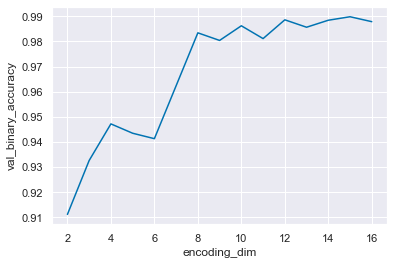

In [36]:
sns.lineplot(data=losses2,x="encoding_dim",y="val_binary_accuracy")

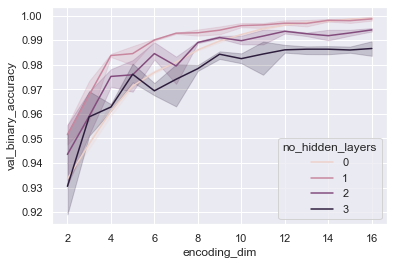

In [46]:
sns.lineplot(data=losses2,x="encoding_dim",y="val_binary_accuracy",hue="no_hidden_layers")

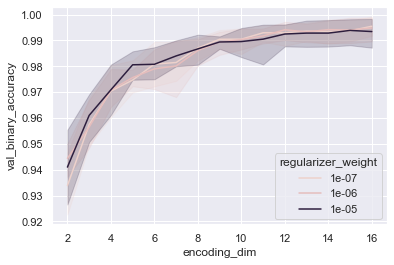

In [49]:
sns.lineplot(data=losses2,x="encoding_dim",y="val_binary_accuracy",hue="regularizer_weight")

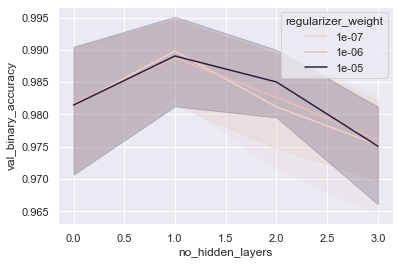

In [48]:
sns.lineplot(data=losses2,x="no_hidden_layers",y="val_binary_accuracy",hue="regularizer_weight")

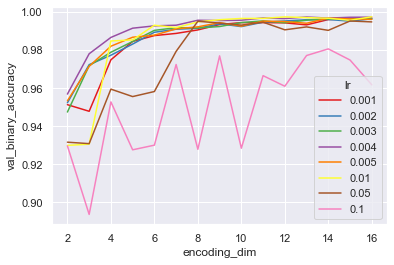

In [63]:
sns.lineplot(data=losses2,x="encoding_dim",y="val_binary_accuracy",hue="lr",palette='Set1')

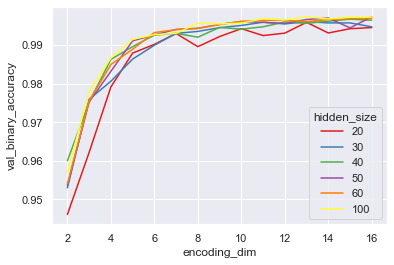

In [78]:
sns.lineplot(data=losses2[(losses2["lr"]==.004)&(losses2["tied_layer"]==False)],x="encoding_dim",y="val_binary_accuracy",hue="hidden_size",palette='Set1')

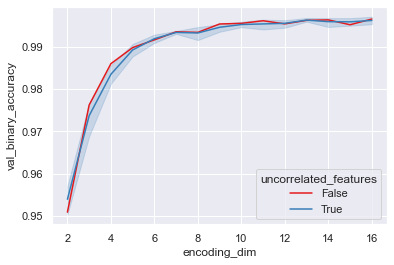

In [81]:
sns.lineplot(data=losses2[(losses2["lr"]==.004)&(losses2["tied_layer"]==False)],x="encoding_dim",y="val_binary_accuracy",hue="uncorrelated_features",palette='Set1')

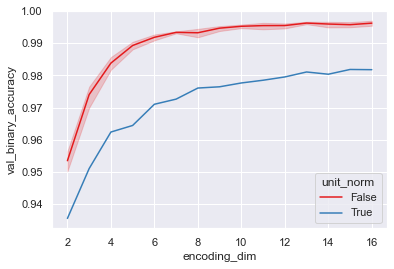

In [84]:
sns.lineplot(data=losses2[(losses2["lr"]==.004)&(losses2["tied_layer"]==False)],x="encoding_dim",y="val_binary_accuracy",hue="unit_norm",palette='Set1')

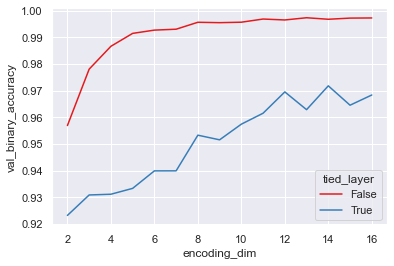

In [68]:
sns.lineplot(data=losses2[losses2["lr"]==.004],x="encoding_dim",y="val_binary_accuracy",hue="tied_layer",palette='Set1')
## hmmm - 

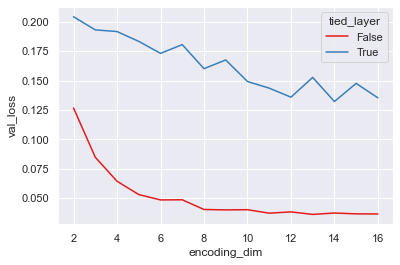

In [70]:
sns.lineplot(data=losses2[losses2["lr"]==.004],x="encoding_dim",y="val_loss",hue="tied_layer",palette='Set1')

In [86]:
autoencoder.summary()

Model: "model_870"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_872 (InputLayer)       [(None, 76)]              0         
_________________________________________________________________
dense_1921 (Dense)           (None, 50)                3850      
_________________________________________________________________
dense_1922 (Dense)           (None, 16)                816       
_________________________________________________________________
dense_1923 (Dense)           (None, 50)                850       
_________________________________________________________________
dense_1924 (Dense)           (None, 76)                3876      
Total params: 9,392
Trainable params: 9,392
Non-trainable params: 0
_________________________________________________________________


0      0.001
1      0.002
2      0.003
3      0.005
4      0.100
       ...  
130    0.004
131    0.004
132    0.004
133    0.004
134    0.004
Name: lr, Length: 135, dtype: float64

In [71]:
autoencoder.summary()

Model: "model_660"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_662 (InputLayer)       [(None, 76)]              0         
_________________________________________________________________
dense_1503 (Dense)           (None, 100)               7700      
_________________________________________________________________
dense_1504 (Dense)           (None, 16)                1616      
_________________________________________________________________
dense_tied_28 (DenseTied)    (None, 100)               3316      
_________________________________________________________________
dense_tied_29 (DenseTied)    (None, 76)                15376     
Total params: 18,692
Trainable params: 9,492
Non-trainable params: 9,200
_________________________________________________________________


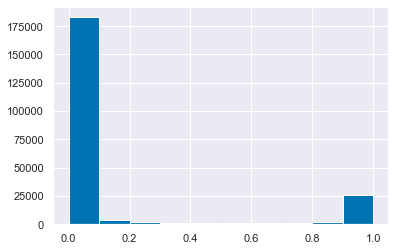

In [25]:
pd.DataFrame(autoencoder.predict(X)).stack().hist()

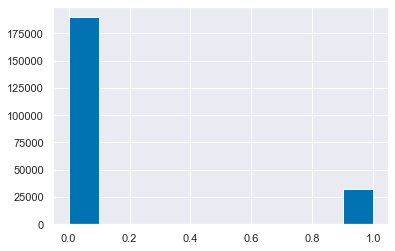

In [26]:
X.stack().hist()

In [29]:
(pd.DataFrame(autoencoder.predict(X))>.5).astype(int)

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2917,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2918,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2919,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [30]:
X.astype('int')

,v851_0.0,v851_1.0,v851_2.0,v851_3.0,v851_4.0,v851_5.0,v851_6.0,v851_7.0,v851_8.0,v851_9.0,...,v857a_9.0,v857b_0.0,v857b_1.0,v857b_2.0,v857b_3.0,v857b_4.0,v857b_5.0,v857b_6.0,v857b_7.0,v857b_9.0
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2918,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2919,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2920,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
## how to look at individual embedding axes???

In [89]:
autoencoder.summary()

Model: "model_872"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_874 (InputLayer)       [(None, 76)]              0         
_________________________________________________________________
dense_1925 (Dense)           (None, 50)                3850      
_________________________________________________________________
dense_1926 (Dense)           (None, 5)                 255       
_________________________________________________________________
dense_1927 (Dense)           (None, 50)                300       
_________________________________________________________________
dense_1928 (Dense)           (None, 76)                3876      
Total params: 8,281
Trainable params: 8,281
Non-trainable params: 0
_________________________________________________________________


In [91]:
encoded_imgs.shape

(964, 5)

In [92]:
X

,v851_0.0,v851_1.0,v851_2.0,v851_3.0,v851_4.0,v851_5.0,v851_6.0,v851_7.0,v851_8.0,v851_9.0,...,v857a_9.0,v857b_0.0,v857b_1.0,v857b_2.0,v857b_3.0,v857b_4.0,v857b_5.0,v857b_6.0,v857b_7.0,v857b_9.0
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2918,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2919,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2920,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [101]:
# %%time
encoded_df = pd.DataFrame(encoder.predict(X.values))

In [105]:
-

# 0
# v1213_9.0   -0.568337
# v1213_3.0    0.451808
# v856_5.0    -0.542233
# v856_9.0     0.846343
# v1212_2.0   -0.413943
# v1212_1.0   -0.379927
# v1212_9.0    0.848863

# 1
# v1214_5.0   -0.490052
# v855_1.0    -0.479482
# v1213_2.0   -0.441620
# v853_3.0    -0.432010
# v854_4.0    -0.419634
#                ...   
# v854_0.0     0.290741
# v1212_3.0    0.341594
# v1214_1.0    0.400426
# v852_0.0     0.481574
# v853_5.0     0.562641

# 2
# v1214_5.0   -0.421215
# v853_3.0    -0.417951
# v1212_3.0   -0.413922
# v1213_3.0   -0.363471
# v855_9.0    -0.352942
#                ...   
# v854_1.0     0.498936
# v853_5.0     0.519035
# v1212_2.0    0.525035
# v1213_2.0    0.545332
# v851_2.0     0.666147

v1214_5.0   -0.421215
v853_3.0    -0.417951
v1212_3.0   -0.413922
v1213_3.0   -0.363471
v855_9.0    -0.352942
               ...   
v854_1.0     0.498936
v853_5.0     0.519035
v1212_2.0    0.525035
v1213_2.0    0.545332
v851_2.0     0.666147
Length: 76, dtype: float64

In [109]:
BES_df_list[ge][drop_vars].dtypes

v851     float64
v852     float64
v853     float64
v854     float64
v855     float64
v1214    float64
v1212    float64
v1213    float64
v856     float64
v857a    float64
v857b    float64
dtype: object

In [ ]:
drop_vars = [ 'v851','v852','v853','v854','v855','v1214','v1212','v1213','v856','v857a','v857b']
X = BES_df_list[ge][drop_vars].astype('category')

In [139]:
replace_dict_by_var = {"v851":
                       {1.0:"LEFT SCH AGE(13-)",
                        2.0:"LEFT SCH AGE(14)",
                        3.0:"LEFT SCH AGE(15)",
                        4.0:"LEFT SCH AGE(16)",
                        5.0:"LEFT SCH AGE(17)",
                        6.0:"LEFT SCH AGE(18)",
                        7.0:"LEFT SCH AGE(>18)",
                        8.0:"LEFT SCH AGE(NEVER)",
                        9.0:"LEFT SCH AGE(DK)",
                        0.0:"LEFT SCH AGE(NA)",
                       },
                       "v852":{
                        1.0:"(IF PAST MIN)LEFT SCH AGE(<14)",
                        2.0:"(IF PAST MIN)LEFT SCH AGE(14)",
                        3.0:"(IF PAST MIN)LEFT SCH AGE(15)",
                        4.0:"(IF PAST MIN)LEFT SCH AGE(16)",
                        5.0:"(IF PAST MIN)LEFT SCH AGE(17)",
                        6.0:"(IF PAST MIN)LEFT SCH AGE(18)",
                        8.0:"(IF PAST MIN)LEFT SCH AGE(>18)",
                        9.0:"(IF PAST MIN)LEFT SCH AGE(STILL)",
                        0.0:"(IF PAST MIN)LEFT SCH AGE(NA)",
                       },
                       "v853":{
                        1.0:"KIND OF SCHOOL1(University)",
                        2.0:"KIND OF SCHOOL1(Public school)",
                        3.0:"KIND OF SCHOOL1(Grammar)",
                        4.0:"KIND OF SCHOOL1(Technical college)",
                        5.0:"KIND OF SCHOOL1(Elementary/2nd Mod/tech)",
                        6.0:"KIND OF SCHOOL1(Commercial schools)",
                        8.0:"KIND OF SCHOOL1(OTH)",
                        9.0:"KIND OF SCHOOL1(DK)",
                        0.0:"KIND OF SCHOOL1(NA)",
                       },
                       "v854":{
                        1.0:"KIND OF SCHOOL2(Elementary/2nd Mod)",
                        2.0:"KIND OF SCHOOL2(Comprehensive)",
                        3.0:"KIND OF SCHOOL2(Technical)",
                        4.0:"KIND OF SCHOOL2(Grammar)",
                        5.0:"KIND OF SCHOOL2(Public school)",
                        6.0:"KIND OF SCHOOL2(Commercial schools)",
                        8.0:"KIND OF SCHOOL2(OTH)",
                        0.0:"KIND OF SCHOOL2(NA)",
                       },
                       "v855":{
                        1.0:"DID YOU STAY IN SCHOOL PAST MIN AGE(YES)",
                        5.0:"DID YOU STAY IN SCHOOL PAST MIN AGE(NO)",
                        9.0:"DID YOU STAY IN SCHOOL PAST MIN AGE(RESP NOT INT)",
                        0.0:"DID YOU STAY IN SCHOOL PAST MIN AGE(NA)",
                       },
                       "v856":{
                        1.0:"ANY FT/PT ED AFTER SCHOOL(YES)",
                        5.0:"ANY FT/PT ED AFTER SCHOOL(NO)",
                        9.0:"ANY FT/PT ED AFTER SCHOOL(RESP NOT INT)",
                        0.0:"ANY FT/PT ED AFTER SCHOOL(NA)",
                       },
                       "v857a":{
                        1.0:"ED AFTER SCHOOL(University)",
                        2.0:"ED AFTER SCHOOL(Technical/professional)",                           
                        3.0:"ED AFTER SCHOOL(College of commerce)",
                        4.0:"ED AFTER SCHOOL(Apprenticeship)",                           
                        5.0:"ED AFTER SCHOOL(Art school)",
                        6.0:"ED AFTER SCHOOL(Night school)",
                        7.0:"ED AFTER SCHOOL(Summer school)",
                        9.0:"ED AFTER SCHOOL(OTH)",
                        0.0:"ED AFTER SCHOOL(NA)",
                       },            
                       "v857b":{
                        1.0:"ED AFTER SCHOOL(University)",
                        2.0:"ED AFTER SCHOOL(Technical/professional)",                           
                        3.0:"ED AFTER SCHOOL(College of commerce)",
                        4.0:"ED AFTER SCHOOL(Apprenticeship)",                           
                        5.0:"ED AFTER SCHOOL(Art school)",
                        6.0:"ED AFTER SCHOOL(Night school)",
                        7.0:"ED AFTER SCHOOL(Summer school)",
                        9.0:"ED AFTER SCHOOL(OTH)",
                        0.0:"ED AFTER SCHOOL(NA)",
                       },                  
                       "v857b":{
                        1.0:"ED AFTER SCHOOL(University)",
                        2.0:"ED AFTER SCHOOL(Technical/professional)",                           
                        3.0:"ED AFTER SCHOOL(College of commerce)",
                        4.0:"ED AFTER SCHOOL(Apprenticeship)",                           
                        5.0:"ED AFTER SCHOOL(Art school)",
                        6.0:"ED AFTER SCHOOL(Night school)",
                        7.0:"ED AFTER SCHOOL(Summer school)",
                        9.0:"ED AFTER SCHOOL(OTH)",
                        0.0:"ED AFTER SCHOOL(NA)",
                       },      
                       "v1212":{
                        1.0:"ED GEN1: COMPULSORY AGE 13 (age 57+)",
                        2.0:"ED GEN1: COMPULSORY AGE 14 (age 30-56)",                           
                        3.0:"ED GEN1: COMPULSORY AGE 15 (age 29-)",
                        9.0:"ED GEN1: RESP NOT INTER",
                        0.0:"ED GEN1: NA",
                       },
                       "v1213":{
                        1.0:"ED GEN2: COMPULSORY AGE 13 (age 60+)",
                        2.0:"ED GEN2: COMPULSORY AGE 14 (age 33-59)",
                        3.0:"ED GEN2: COMPULSORY AGE 15 (age 32-)",
                        9.0:"ED GEN2: RESP NOT INTER",
                        0.0:"ED GEN2: NA",
                       },
                       "v1214":{
                        1.0:"LEFT SCHOOL AT MIN AGE (YES)",                     
                        5.0:"LEFT SCHOOL AT MIN AGE (NO)",
                        9.0:"LEFT SCHOOL AT MIN AGE (RESP WAS FIRST IN)",
                        0.0:"LEFT SCHOOL AT MIN AGE (NA)",
                       }
                      }
 

In [128]:
# BES_df_list[ge][drop_vars]

In [141]:
columns_labels = flatten([replace_dict_by_var[x].values() for x in BES_df_list[ge][drop_vars].columns])

In [121]:
# %%time
encoded_df = pd.DataFrame(encoder.predict(X.values))
encoded_df

,0,1,2,3,4
0,1.334551,14.794837,10.751409,6.044950,15.344945
1,1.055738,14.275659,16.464428,5.406850,18.350777
2,4.380843,13.580643,10.965240,6.164793,11.614425
3,7.829073,9.349864,11.781991,22.480116,21.140062
4,5.345652,11.996524,18.911268,5.940810,17.927895
...,...,...,...,...,...
2916,18.450493,19.381712,8.797875,4.754414,15.561533
2917,18.450493,19.381712,8.797875,4.754414,15.561533
2918,13.992740,11.610109,5.347777,0.000000,13.855875
2919,19.704147,13.614383,22.562897,6.668358,11.897131


In [149]:
X_named = X
X_named.columns = columns_labels
X_named.corrwith(encoded_df[4]).sort_values()



KIND OF SCHOOL2(Comprehensive)                      -0.555389
DID YOU STAY IN SCHOOL PAST MIN AGE(RESP NOT INT)   -0.472319
DID YOU STAY IN SCHOOL PAST MIN AGE(NO)             -0.451394
(IF PAST MIN)LEFT SCH AGE(17)                       -0.336543
ED AFTER SCHOOL(University)                         -0.299542
                                                       ...   
ED AFTER SCHOOL(Summer school)                       0.308375
ED GEN2: NA                                          0.320719
(IF PAST MIN)LEFT SCH AGE(<14)                       0.446288
DID YOU STAY IN SCHOOL PAST MIN AGE(NA)              0.745672
KIND OF SCHOOL2(Elementary/2nd Mod)                  0.746317
Length: 76, dtype: float64

In [ ]:
# 0
# ED GEN2: NA                               -0.568337
# ANY FT/PT ED AFTER SCHOOL(RESP NOT INT)   -0.542233
# ED GEN1: COMPULSORY AGE 15 (age 29-)      -0.413943
# ED GEN1: COMPULSORY AGE 14 (age 30-56)    -0.379927

# ED GEN2: COMPULSORY AGE 15 (age 32-)       0.186236
# DID YOU STAY IN SCHOOL PAST MIN AGE(NO)    0.238290
# ED GEN2: RESP NOT INTER                    0.451808
# ANY FT/PT ED AFTER SCHOOL(NA)              0.846343
# ED GEN1: NA                                0.848863

In [ ]:
# 1
# LEFT SCHOOL AT MIN AGE (RESP WAS FIRST IN)   -0.490052
# DID YOU STAY IN SCHOOL PAST MIN AGE(NO)      -0.479482
# ED GEN2: COMPULSORY AGE 15 (age 32-)         -0.441620
# KIND OF SCHOOL1(Technical college)           -0.432010
# KIND OF SCHOOL2(Public school)               -0.419634

# KIND OF SCHOOL2(Elementary/2nd Mod)           0.290741
# ED GEN1: RESP NOT INTER                       0.341594
# LEFT SCHOOL AT MIN AGE (NO)                   0.400426
# (IF PAST MIN)LEFT SCH AGE(<14)                0.481574
# KIND OF SCHOOL1(Commercial schools)           0.562641

In [148]:
# 2
# LEFT SCHOOL AT MIN AGE (RESP WAS FIRST IN)   -0.421215
# KIND OF SCHOOL1(Technical college)           -0.417951
# ED GEN1: RESP NOT INTER                      -0.413922
# ED GEN2: RESP NOT INTER                      -0.363471
# DID YOU STAY IN SCHOOL PAST MIN AGE(NA)      -0.352942

# KIND OF SCHOOL2(Comprehensive)                0.498936
# KIND OF SCHOOL1(Commercial schools)           0.519035
# ED GEN1: COMPULSORY AGE 15 (age 29-)          0.525035
# ED GEN2: COMPULSORY AGE 15 (age 32-)          0.545332
# LEFT SCH AGE(15)                              0.666147

In [ ]:
# 3
# ED AFTER SCHOOL(University)                  -0.917007
# ANY FT/PT ED AFTER SCHOOL(RESP NOT INT)      -0.575299
# (IF PAST MIN)LEFT SCH AGE(<14)               -0.324851
# ANY FT/PT ED AFTER SCHOOL(NA)                -0.268248
# LEFT SCHOOL AT MIN AGE (NO)                  -0.261095
#                                                 ...   
# LEFT SCHOOL AT MIN AGE (RESP WAS FIRST IN)    0.219766
# DID YOU STAY IN SCHOOL PAST MIN AGE(NO)       0.326270
# ED AFTER SCHOOL(College of commerce)          0.332939
# ED AFTER SCHOOL(Summer school)                0.710591
# ANY FT/PT ED AFTER SCHOOL(NO)                 0.917560

In [ ]:
# 4
# KIND OF SCHOOL2(Comprehensive)                      -0.555389
# DID YOU STAY IN SCHOOL PAST MIN AGE(RESP NOT INT)   -0.472319
# DID YOU STAY IN SCHOOL PAST MIN AGE(NO)             -0.451394
# (IF PAST MIN)LEFT SCH AGE(17)                       -0.336543
# ED AFTER SCHOOL(University)                         -0.299542

# ED AFTER SCHOOL(Summer school)                       0.308375
# ED GEN2: NA                                          0.320719
# (IF PAST MIN)LEFT SCH AGE(<14)                       0.446288
# DID YOU STAY IN SCHOOL PAST MIN AGE(NA)              0.745672
# KIND OF SCHOOL2(Elementary/2nd Mod)                  0.746317

In [153]:
autoencoder.summary()

Model: "model_872"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_874 (InputLayer)       [(None, 76)]              0         
_________________________________________________________________
dense_1925 (Dense)           (None, 50)                3850      
_________________________________________________________________
dense_1926 (Dense)           (None, 5)                 255       
_________________________________________________________________
dense_1927 (Dense)           (None, 50)                300       
_________________________________________________________________
dense_1928 (Dense)           (None, 76)                3876      
Total params: 8,281
Trainable params: 8,281
Non-trainable params: 0
_________________________________________________________________


In [156]:
autoencoder.layers[3].input

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_1926')>

In [161]:
autoencoder.layers[0].input

<KerasTensor: shape=(None, 76) dtype=float32 (created by layer 'input_874')>

In [166]:
autoencoder.layers[2].output[:,3]

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.getitem_2')>

In [168]:
X

,LEFT SCH AGE(13-),LEFT SCH AGE(14),LEFT SCH AGE(15),LEFT SCH AGE(16),LEFT SCH AGE(17),LEFT SCH AGE(18),LEFT SCH AGE(>18),LEFT SCH AGE(NEVER),LEFT SCH AGE(DK),LEFT SCH AGE(NA),...,ED AFTER SCHOOL(NA),ED AFTER SCHOOL(University),ED AFTER SCHOOL(Technical/professional),ED AFTER SCHOOL(College of commerce),ED AFTER SCHOOL(Apprenticeship),ED AFTER SCHOOL(Art school),ED AFTER SCHOOL(Night school),ED AFTER SCHOOL(Summer school),ED AFTER SCHOOL(OTH),ED AFTER SCHOOL(NA)
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2918,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2919,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2920,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [214]:
explainer = shap.DeepExplainer(
    (autoencoder.layers[0].input, autoencoder.layers[1].output), X.values
)

In [216]:
shap_values,indexes = explainer.shap_values(X.values)

AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of 167.685150 is significant compared the scale of your model outputs please post as a github issue, with a reproducable example if possible so we can debug it.

In [217]:
encoder.summary()

Model: "model_873"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_874 (InputLayer)       [(None, 76)]              0         
_________________________________________________________________
dense_1925 (Dense)           (None, 50)                3850      
_________________________________________________________________
dense_1926 (Dense)           (None, 5)                 255       
Total params: 4,105
Trainable params: 4,105
Non-trainable params: 0
_________________________________________________________________


In [218]:
explainer = shap.KernelExplainer(
    encoder, X[0:10].values
)

In [219]:
shap_values = explainer.shap_values(X.values)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [193]:
import tensorflow_datasets as tfds

tfds.disable_progression_bar()

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [207]:
IProgress

ipywidgets.widgets.widget_int.IntProgress

In [211]:
from ipywidgets import IntProgress as IProgress

In [212]:
from ipywidgets import FloatProgress

In [ ]:
# explain how the input to the 7th layer of the model explains the top two classes
explainer = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(preprocess_input(X.copy()), 7),
    local_smoothing=100
)
shap_values,indexes = explainer.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)